In [1]:
import os 
import re
import glob
import pywt
import joblib

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
PATH = 'data/synthetic/spectra/simulated_data/'
GENERATED_FILES_OUTPUT= 'data/synthetic/generated_files/'
MODELS_OUTPUT = 'data/models/'
PARAMETERS_OUTPUT = 'data/synthetic/params/'

# create all directories if they don't exist
for directory in [GENERATED_FILES_OUTPUT, MODELS_OUTPUT, PARAMETERS_OUTPUT]:
    if not os.path.exists(directory):
        os.makedirs(directory)

files = sorted(glob.glob(PATH + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

write_data = open(PARAMETERS_OUTPUT + 'model_parameters_data_all_10K.txt', 'w')

# read in all files
for file in files:
    with open(file, 'r') as f:
        # skip the first 10 lines in each file
        for i in range(10):
            f.readline()
        # read in the data from each file
        data = f.readlines()
        # write the data to the output file in the same order as the files
        for i in range(len(data)):
            write_data.write(data[i])

write_data.close()  

In [3]:
# get the params data
df_param = pd.DataFrame()
for file in files:
    # get the parameters used
    df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
    # save the dataframe to a csv file
df_param.to_csv(PARAMETERS_OUTPUT + 'model_parameters_data_10K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(PARAMETERS_OUTPUT + 'model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [5]:
df_data.shape

(580000000, 2)

In [6]:
df_param = pd.read_csv(PARAMETERS_OUTPUT + 'model_parameters_data_10K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  9.035557e+18  cm-2
2   tex  =  1.313036e+02     K
3  fwhm  =  2.933735e+00  km/s
4  vlsr  =  1.702059e+01  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A       fwhm          ntot      size  tcmb         tex       vlsr
g                                                                
0   2.933735  9.035557e+18  1.332560  2.73  131.303629  17.020590
1   6.144747  1.329373e+18  0.388745  2.73   68.564338  13.937171
2   5.936799  7.038781e+17  2.270334  2.73  306.109908  32.571172
3  10.075154  7.898081e+16  0.465409  2.73   53.727434 -12.442107
4   6.654279  6.687129e+16  0.464912  2.73  374.698519 -27.878288
5   3.197202  1.579432e+16  0.417047  2.73  299.269394  -4.419249
6   6.269222  1.975123e+18  1.419747  2.73  154.224519 -12.908657
7   5.466756  2.304166e+16  1.044501  2.73  373.507560  18.794082
8   4.527537  1.831597e+17  0.635137  2.73   12.217461 -39.213550
9   5.542682  1.333910e+16  0.926891  2.73   90.838083  18.021617

In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(580000000, 2)

In [12]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

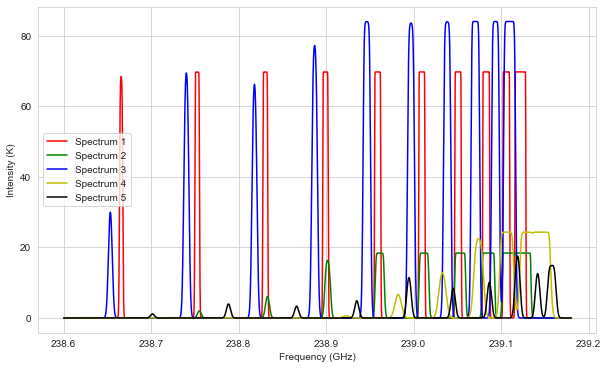

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

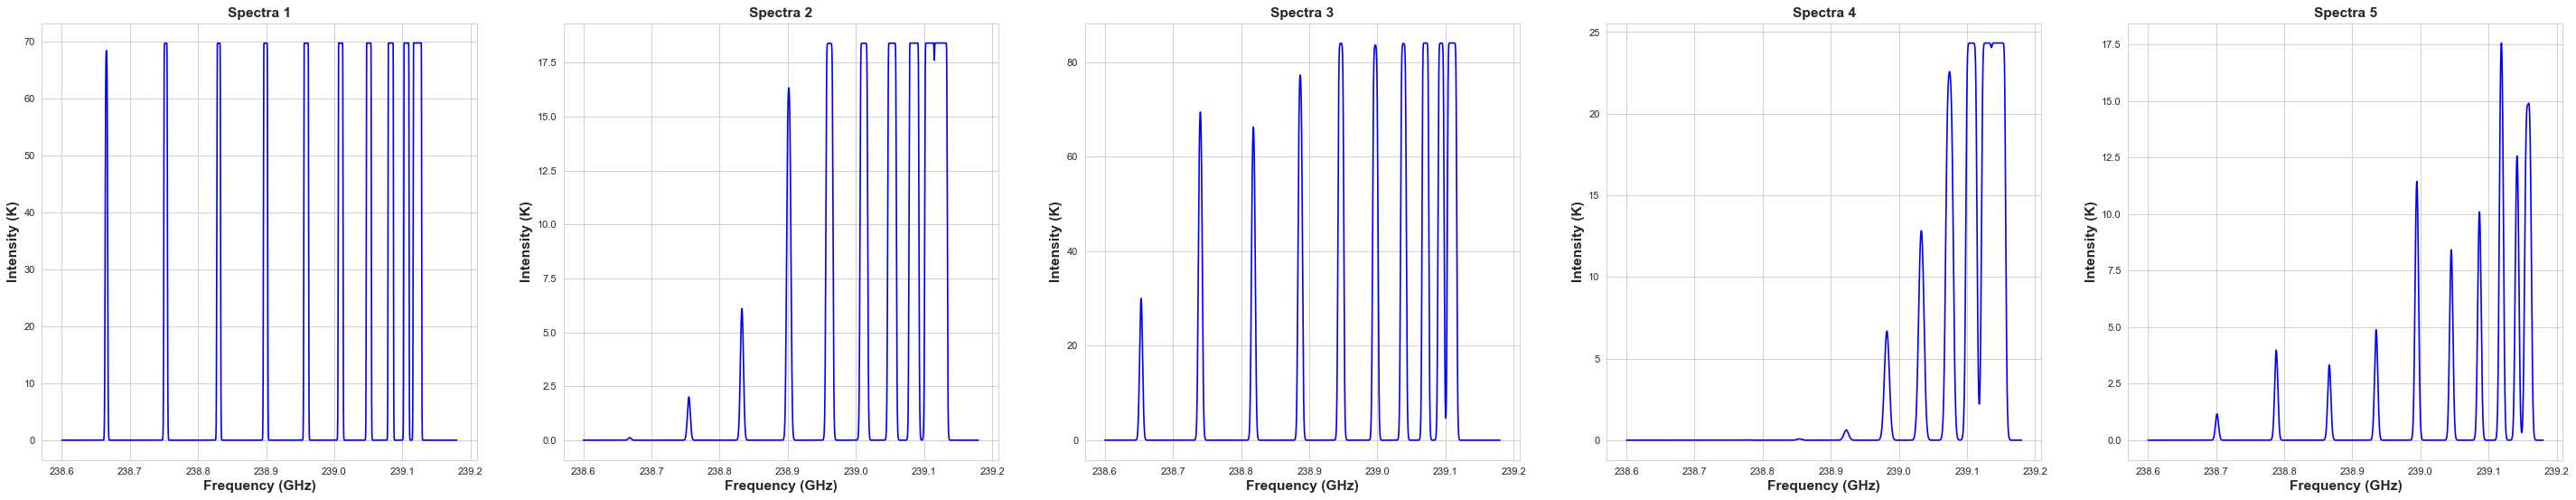

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(45, 8), dpi=80)
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1],  color='blue')
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title("Spectra {}".format(i), fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.grid(True)
plt.show()   
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 454))
approx_coeffs = np.zeros((len(signal), 454))
level = 7
wname = 'db1'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # level 7 detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(10000, 58000)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
579999995  239.17995        0.0
579999996  239.17996        0.0
579999997  239.17997        0.0
579999998  239.17998        0.0
579999999  239.17999        0.0

[580000000 rows x 2 columns]

In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.97996253e-02,  1.80828541e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.73081071e-02,  4.49013447e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(10000, 454)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

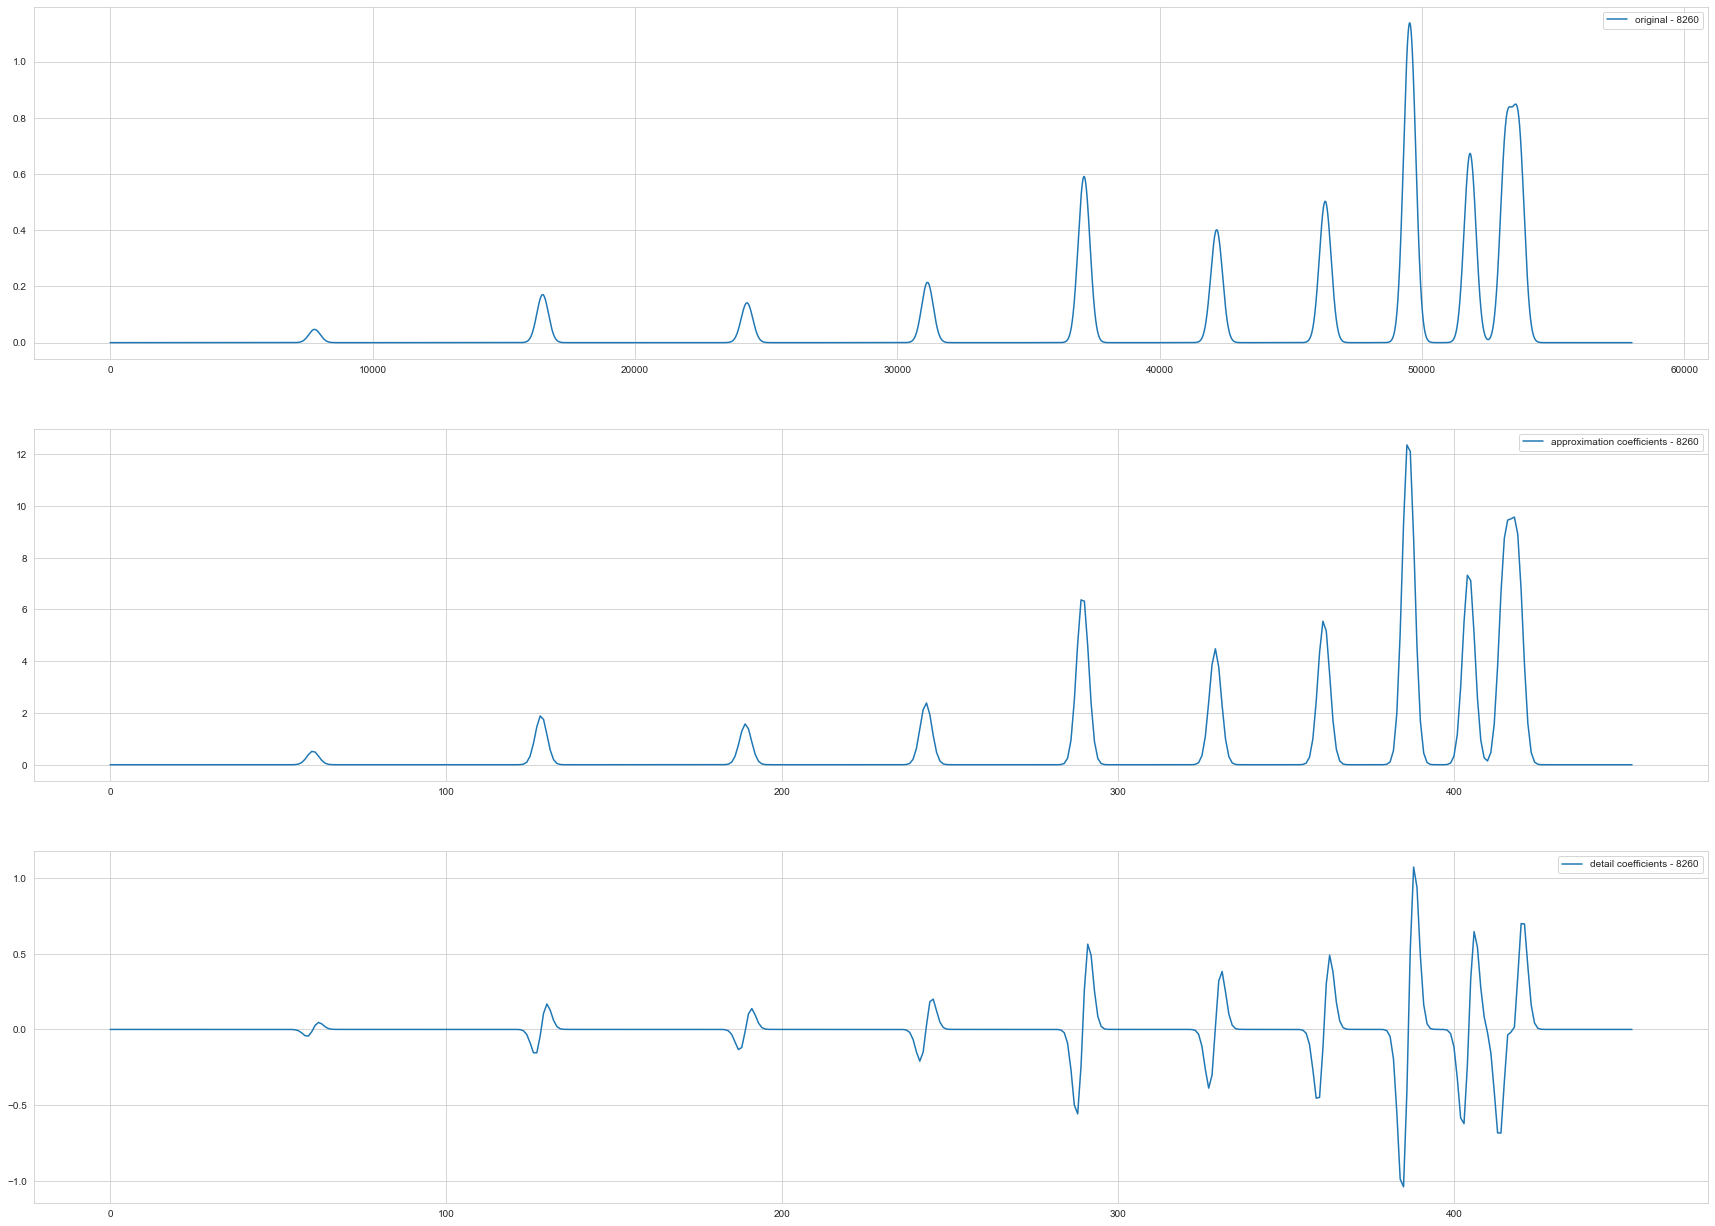

In [27]:
plt.figure(figsize=(30,22))
plt.subplot(3,1,1)
plt.plot(signal[8260], label='original - 8260')
plt.legend()
plt.subplot(3,1,2)
plt.plot(approx_coeffs[8260], label='approximation coefficients - 8260')
plt.legend()
plt.subplot(3,1,3)
plt.plot(detail_coeffs[8260], label='detail coefficients - 8260')
plt.legend()
# save the subplots in a pdf file
plt.savefig(GENERATED_FILES_OUTPUT + 'dwt_signal_8260.pdf', dpi=15000)


In [28]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (10000, 454) labels_shape:  (10000, 6)


In [29]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

In [30]:
df = pd.DataFrame(approx_coeffs)
df.head()

0    1    2    3    4    5    6    7    8    9    ...       444       445  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000040  0.000004   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.129967  0.012772   

            446           447           448           449           450  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  3.108292e-07  2.209523e-08  1.366149e-09  7.346935e-11  3.437195e-12   
4  9.147949e-04  4.774608e-05  1.815184e-06  5.024470e-08  1.012212e-09   

            451           452  453  
0  0.000000e+00  0.000000e+00  0.0  
1  0.000000e+00  0.000000e+00  0.0  
2  0.000000e+00  0.000000e+00  0.0  
3  1.406288e-13  1.189836e-15  0.0  
4  1.483558e-11  1.568743e-13  0.0  

[5 rows x 454 columns]

In [31]:
df = pd.concat([df, labels_], axis=1)
df.head()

0    1    2    3    4    5    6    7    8    9  ...           449  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  7.346935e-11   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.024470e-08   

            450           451           452  453       fwhm          ntot  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.0   2.933735  9.035557e+18   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.0   6.144747  1.329373e+18   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.0   5.936799  7.038781e+17   
3  3.437195e-12  1.406288e-13  1.189836e-15  0.0  10.075154  7.898081e+16   
4  1.012212e-09  1.483558e-11  1.568743e-13  0.0   6.654279  6.687129e+16   

       size         tex       vlsr  
0  1.332560  131.303629  17.020590  
1  0.388745   68.564338  13.937171  
2  2.270334  306.109908  32.571172  
3  0.465409   53.727434 -12.442107  
4  0.464912  374.698519 -27.878288  

[5 rows x 459 columns]

In [32]:
df.shape

(10000, 459)

In [33]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0    1    2    3    4    5    6    7    8    9  ...           449  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000e+00   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  7.346935e-11   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.024470e-08   

            450           451           452  453       fwhm       ntot  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.0   2.933735  18.955955   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.0   6.144747  18.123647   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.0   5.936799  17.847497   
3  3.437195e-12  1.406288e-13  1.189836e-15  0.0  10.075154  16.897522   
4  1.012212e-09  1.483558e-11  1.568743e-13  0.0   6.654279  16.825240   

       size         tex       vlsr  
0  1.332560  131.303629  17.020590  
1  0.388745   68.564338  13.937171  
2  2.270334  306.109908  32.571172  
3  0.465409   53.727434 -12.442107  
4  0.464912  374.698519 -27.878288  

[5 rows x 459 columns]

In [34]:
X = df.iloc[:, :454]
y = df.iloc[:, -5:]

In [35]:
X

0    1    2    3    4    5    6             7             8    \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
...   ...  ...  ...  ...  ...  ...  ...           ...           ...   
9995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
9996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.597474e-14  5.866454e-13   
9997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
9998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   
9999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000e+00  0.000000e+00   

               9    ...         444         445           446           447  \
0     0.000000e+00  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   
1     0.000000e+00  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   
2     0.000000e+00  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   
3     0.000000e+00  ...    0.000040    0.000004  3.108292e-07  2.209523e-08   
4     0.000000e+00  ...    0.129967    0.012772  9.147949e-04  4.774608e-05   
...            ...  ...         ...         ...           ...           ...   
9995  0.000000e+00  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   
9996  7.709770e-12  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   
9997  0.000000e+00  ...  123.336231  130.237609  1.054364e+02  5.726366e+01   
9998  0.000000e+00  ...   31.534633   50.307724  9.051485e+01  1.448223e+02   
9999  0.000000e+00  ...    0.000000    0.000000  0.000000e+00  0.000000e+00   

               448           449           450           451           452  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     1.366149e-09  7.346935e-11  3.437195e-12  1.406288e-13  1.189836e-15   
4     1.815184e-06  5.024470e-08  1.012212e-09  1.483558e-11  1.568743e-13   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9997  1.976785e+01  4.273924e+00  5.811346e-01  4.992328e-02  2.711645e-03   
9998  2.003524e+02  2.446475e+02  2.714690e+02  2.802741e+02  2.714279e+02   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

             453  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  
...          ...  
9995    0.000000  
9996    0.000000  
9997    0.000278  
9998  259.080425  
9999    0.000000  

[10000 rows x 454 columns]

In [36]:
y

fwhm       ntot      size         tex       vlsr
0      2.933735  18.955955  1.332560  131.303629  17.020590
1      6.144747  18.123647  0.388745   68.564338  13.937171
2      5.936799  17.847497  2.270334  306.109908  32.571172
3     10.075154  16.897522  0.465409   53.727434 -12.442107
4      6.654279  16.825240  0.464912  374.698519 -27.878288
...         ...        ...       ...         ...        ...
9995   4.909492  18.609729  1.719104  348.597741   6.530393
9996  10.977503  16.330423  0.664250  336.116661  49.761659
9997   5.506002  16.027427  1.213782  300.825404 -40.673135
9998   8.829258  16.416385  1.857922  342.955614 -52.942065
9999   4.976429  16.250681  0.369198   78.534453   2.518707

[10000 rows x 5 columns]

#### split the data into the training and test set

In [37]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (7000, 454) 
 y_train shape:  (7000, 5) 
 X_test shape:  (3000, 454) 
 y_test shape:  (3000, 5)


In [38]:
# get the original data indices for the test data and save them in a csv file
testing_data_indices = pd.DataFrame(X_test.index)
testing_data_indices.to_csv(PARAMETERS_OUTPUT + "testing_data_indices.csv")

## 1. Multioutput Regressor - RF

In [39]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))


# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 1 of 700
building tree 5 of 700
building tree 4 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 16 of 700
building tree 14 of 700
building tree 15 of 700
building tree 18 of 700
building tree 20 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s


building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 50 of 700
building tree 49 of 700
building tree 53 of 700
building tree 54 of 700
building tree 52 of 700
building tree 55 of 700
building tree 51 of 700
building tree 57 of 700
building tree 56 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 65 of 700
building tree 69 of 700building tree 67 of 700

building tree 58 of 700
building tree 60 of 700
building tree 71 of 700
building tree 64 of 700
building tree 70 of 700
building tree 62 of 700
building tree 66 of 700
building tree 68 of 700
building tree 72 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 74 of 700
building tree 79 of 700
building tree 76 of 700
building tree 83 of 700
building tree 78 of 700
building tree 87 of 700
building tree 80 of 700
building tree 81 of 700
building tree 84 of 700
building tree 85 of 700
building tree 89

[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   11.8s


building tree 260 of 700
building tree 261 of 700
building tree 263 of 700
building tree 265 of 700
building tree 267 of 700
building tree 269 of 700
building tree 271 of 700
building tree 273 of 700
building tree 262 of 700
building tree 266 of 700
building tree 270 of 700
building tree 264 of 700
building tree 272 of 700
building tree 275 of 700
building tree 268 of 700
building tree 274 of 700
building tree 277 of 700
building tree 279 of 700
building tree 276 of 700
building tree 281 of 700
building tree 283 of 700
building tree 285 of 700
building tree 287 of 700
building tree 289 of 700
building tree 278 of 700
building tree 288 of 700
building tree 282 of 700
building tree 286 of 700
building tree 280 of 700
building tree 284 of 700
building tree 290 of 700
building tree 291 of 700
building tree 293 of 700
building tree 295 of 700
building tree 297 of 700
building tree 299 of 700
building tree 301 of 700
building tree 292 of 700
building tree 294 of 700
building tree 296 of 700


[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   15.1s


building tree 668 of 700
building tree 670 of 700
building tree 672 of 700
building tree 673 of 700
building tree 677 of 700
building tree 675 of 700
building tree 679 of 700
building tree 681 of 700
building tree 683 of 700
building tree 674 of 700
building tree 676 of 700
building tree 678 of 700
building tree 685 of 700
building tree 687 of 700
building tree 680 of 700
building tree 682 of 700
building tree 684 of 700
building tree 686 of 700
building tree 689 of 700
building tree 691 of 700
building tree 693 of 700
building tree 688 of 700
building tree 695 of 700
building tree 694 of 700
building tree 690 of 700
building tree 692 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 696 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 6 of 700building tree 4 of 700

building tree 2 of 700
building tree 7 of 700building tree 3 of 700

building tree 5 of 700
building tree 1 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 16 of 700
building tree 15 of 700building tree 13 of 700

building tree 14 of 700
building tree 12 of 700
building tree 17 of 700
building tree 21 of 700
building tree 19 of 700
building tree 23 of 700
building tree 25 of 700
building tree 18 of 700
building tree 27 of 700
building tree 22 of 700
building tree 31 of 700
building tree 29 of 700
building tree 20 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 32 of 700
building tree 30 of 700
building tree 35 of 700
building tree 33 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 47 of 700
building tree 45 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 67 of 700
building tree 69 of 700
building tree 73 of 700
building tree 71 of 700
building tree 77 of 700
building tree 75 of 700
building tree 79 of 700
building tree 68 of 700
building tree 66 of 700
building tree 70 of 700
building tree 74 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80 of 700
building tree 78 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 82 of 700
building tree 95 of 700
building tree 86 of 700
building tree 84 of 700
building tree 88 of 700
building tree 90 of 700
building tree 92 of 700
building tree 96 of 700
building tree 94 of 700
building tree 97 of 700
building tree 99 of 700
building tree 101 of 700
building tree 100 of 700
building tree 103 of 700
building tree 98 of 700
building tree 109 of 700
building tree 102 of 700
building tree 107 of 700
building tree 105 of 700
building 

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.0s


building tree 304 of 700
building tree 305 of 700
building tree 307 of 700
building tree 306 of 700
building tree 309 of 700
building tree 308 of 700
building tree 311 of 700building tree 317 of 700

building tree 315 of 700
building tree 319 of 700
building tree 313 of 700
building tree 310 of 700
building tree 314 of 700
building tree 312 of 700
building tree 318 of 700
building tree 316 of 700
building tree 320 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 324 of 700
building tree 322 of 700
building tree 326 of 700
building tree 329 of 700building tree 333 of 700

building tree 335 of 700
building tree 331 of 700
building tree 328 of 700
building tree 330 of 700
building tree 332 of 700
building tree 334 of 700
building tree 336 of 700
building tree 337 of 700
building tree 339 of 700
building tree 341 of 700
building tree 343 of 700
building tree 345 of 700
building tree 347 of 700
building tree 338 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    7.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    7.5s finished


building tree 694 of 700
building tree 696 of 700
building tree 695 of 700
building tree 697 of 700
building tree 699 of 700building tree 698 of 700

building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 8 of 700
building tree 7 of 700
building tree 1 of 700
building tree 2 of 700
building tree 4 of 700
building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 12 of 700building tree 14 of 700
building tree 10 of 700
building tree 9 of 700

building tree 13 of 700
building tree 11 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 20 of 700
building tree 22 of 700
building tree 31 of 700
building tree 29 of 700
building tree 18 of 700
building tree 26 of 700
building tree 24 of 700
building tree 28 of 700
building tree 32 of 700
building tree 30 of 700
building tree 37 of 700
building tree 35 of 700
building tree 33 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 34 of 700
building tree 47 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 50 of 700
building tree 54 of 700
building tree 58 of 700
building tree 52 of 700
building tree 56 of 700
building tree 60 of 700
building tree 64 of 700
building tree 62 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 66 of 700
building tree 70 of 700
building tree 68 of 700
building tree 72 of 700
building tree 76 of 700
building tree 74 of 700
building tree 80 of 700
building tree 78 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 89 of 700
building tree 91 of 700
building tree 87 of 700
building tree 93 of 700
building tree 95 of 700
building tree 84 of 700
building tree 82 of 700
building tree 86 of 700
building tree 90 of 700
building tree 88

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.8s


building tree 290 of 700
building tree 301 of 700
building tree 292 of 700
building tree 296 of 700
building tree 298 of 700
building tree 303 of 700
building tree 294 of 700
building tree 300 of 700
building tree 305 of 700
building tree 307 of 700
building tree 302 of 700
building tree 304 of 700
building tree 309 of 700
building tree 313 of 700building tree 311 of 700

building tree 315 of 700
building tree 306 of 700
building tree 317 of 700
building tree 308 of 700
building tree 310 of 700
building tree 312 of 700
building tree 314 of 700
building tree 316 of 700
building tree 321 of 700
building tree 319 of 700
building tree 323 of 700
building tree 318 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 320 of 700
building tree 324 of 700
building tree 331 of 700
building tree 322 of 700
building tree 333 of 700
building tree 326 of 700
building tree 328 of 700
building tree 330 of 700
building tree 332 of 700
building tree 335 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    9.1s remaining:    0.2s


building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 700 of 700
building tree 699 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 1 of 700
building tree 7 of 700building tree 5 of 700
building tree 3 of 700
building tree 6 of 700
building tree 4 of 700

building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 31 of 700
building tree 24 of 700
building tree 22 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 45 of 700
building tree 41 of 700
building tree 43 of 700
building tree 36 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 50 of 700
building tree 52 of 700
building tree 54 of 700
building tree 57 of 700
building tree 59 of 700
building tree 56 of 700
building tree 63 of 700
building tree 61 of 700
building tree 58 of 700
building tree 60 of 700
building tree 64 of 700
building tree 67 of 700
building tree 69 of 700
building tree 65 of 700
building tree 62 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 68 of 700
building tree 77 of 700
building tree 66 of 700
building tree 70 of 700
building tree 72 of 700
building tree 74 of 700
building tree 79 of 700
building tree 76 of 700
building tree 81 of 700
building tree 78 of 700
building tree 83 of 700
building tree 85 of 700
building tree 80 of 700
building tree 87 of 700
building tree 82 of 700
building tree 89 of 700
building tree 84 of 700
building tree 91 of 700
building tree 93 of 700
building tree 86 of 700
building tree 95

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.8s


building tree 307 of 700
building tree 298 of 700
building tree 300 of 700
building tree 302 of 700
building tree 306 of 700
building tree 304 of 700
building tree 309 of 700
building tree 311 of 700
building tree 308 of 700
building tree 313 of 700
building tree 315 of 700
building tree 310 of 700
building tree 312 of 700
building tree 314 of 700
building tree 317 of 700
building tree 316 of 700
building tree 319 of 700
building tree 321 of 700
building tree 323 of 700
building tree 318 of 700
building tree 325 of 700
building tree 327 of 700
building tree 320 of 700
building tree 322 of 700
building tree 324 of 700
building tree 331 of 700
building tree 329 of 700
building tree 326 of 700
building tree 333 of 700
building tree 328 of 700
building tree 335 of 700
building tree 332 of 700
building tree 330 of 700
building tree 334 of 700
building tree 337 of 700
building tree 336 of 700
building tree 339 of 700
building tree 341 of 700
building tree 343 of 700
building tree 338 of 700


[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    6.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 6 of 700
building tree 5 of 700
building tree 8 of 700
building tree 4 of 700
building tree 3 of 700
building tree 1 of 700
building tree 7 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 18 of 700
building tree 29 of 700
building tree 20 of 700
building tree 31 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 37 of 700
building tree 35 of 700
building tree 33 of 700
building tree 39 of 700
building tree 41 of 700
building tree 36 of 700
building tree 34 of 700
building tree 38 of 700
building tree 45 of 700building tree 43 of 700

b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 51 of 700
building tree 78 of 700
building tree 74 of 700
building tree 55 of 700
building tree 67 of 700
building tree 59 of 700
building tree 63 of 700
building tree 71 of 700
building tree 56 of 700
building tree 52 of 700
building tree 64 of 700
building tree 75 of 700
building tree 60 of 700
building tree 79 of 700
building tree 68 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80 of 700
building tree 81 of 700
building tree 85 of 700
building tree 82 of 700
building tree 86 of 700
building tree 89 of 700
building tree 93 of 700
building tree 101 of 700
building tree 97 of 700
building tree 105 of 700
building tree 109 of 700
building tree 90 of 700
building tree 83 of 700
building tree 94 of 700
building tree 87 of 700
building tree 98 of 700
building tree 102 of 700
building tree 106 of 700
building tree 91 of 700
building tree 110 of 700
building tree 95 of 700
building tree 84 of 700
building tree 103 of 700
building tree 99 of 700
building 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.0s


building tree 534 of 700
building tree 523 of 700
building tree 516 of 700
building tree 527 of 700
building tree 531 of 700
building tree 520 of 700
building tree 524 of 700
building tree 541 of 700
building tree 537 of 700
building tree 535 of 700
building tree 528 of 700
building tree 532 of 700
building tree 545 of 700
building tree 549 of 700
building tree 542 of 700
building tree 536 of 700
building tree 538 of 700
building tree 546 of 700
building tree 543 of 700
building tree 553 of 700
building tree 539 of 700
building tree 550 of 700
building tree 561 of 700
building tree 557 of 700
building tree 554 of 700
building tree 565 of 700
building tree 547 of 700
building tree 540 of 700
building tree 562 of 700
building tree 558 of 700
building tree 551 of 700
building tree 544 of 700
building tree 566 of 700
building tree 555 of 700
building tree 548 of 700
building tree 559 of 700
building tree 563 of 700
building tree 552 of 700
building tree 569 of 700
building tree 556 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    5.8s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [40]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

In [41]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(

0.8350519797379568

### Metrics

In [42]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))

In [43]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  10.237110304135035
Multirf  mse:  785.1133916068488
Multirf  rmse:  28.019874939172173
Multirf  mape:  fwhm     4.273989
ntot     1.861500
size    26.960178
tex     36.225667
vlsr     5.385914
dtype: float64
Multirf  r2:  0.8350519797379568
Multirf  msle:  28.019874939172173


#### Save the model

In [44]:
joblib.dump(regr_multirf, MODELS_OUTPUT + "rf_model.pkl")

['data/models/rf_model.pkl']

### save the true params used for the training set to a file

In [45]:
test_values = y_test.values
df_true_params = pd.DataFrame(test_values, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
df_true_params['ntot'] = np.array(10**df_true_params['ntot'])
df_true_params.to_csv(GENERATED_FILES_OUTPUT + "true_param_vals.csv")
df_true_params.head()

fwhm          ntot      size         tex       vlsr
6252  4.376518  2.172053e+18  1.037283  211.416223 -17.763557
4684  1.259056  9.149960e+16  1.913540   69.341427  13.110974
1731  3.166229  3.556430e+16  0.228809   17.409743   1.464466
4742  2.340026  1.211247e+16  1.979907  389.335414  28.010385
4521  3.609998  1.229299e+18  1.737984  235.127786  34.854634

### save the predicted parameters to a csv file 

In [46]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
param_df_rf.head()

fwhm       ntot      size         tex       vlsr
6252  4.489740  18.212957  1.200897  243.386491 -17.831494
4684  1.524747  17.162797  1.890326  118.199462  13.287437
1731  2.523516  16.802196  0.462849   87.034018   1.584097
4742  2.106135  16.983757  0.688151  229.566506  28.010700
4521  3.664536  18.181982  1.776172  241.248424  34.715283

In [47]:
# convert back the log to linear values 
param_df_rf['ntot'] = np.array(10**param_df_rf['ntot'])
param_df_rf.head()

fwhm          ntot      size         tex       vlsr
6252  4.489740  1.632891e+18  1.200897  243.386491 -17.831494
4684  1.524747  1.454780e+17  1.890326  118.199462  13.287437
1731  2.523516  6.341560e+16  0.462849   87.034018   1.584097
4742  2.106135  9.632910e+16  0.688151  229.566506  28.010700
4521  3.664536  1.520483e+18  1.776172  241.248424  34.715283

In [48]:
param_df_rf.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(3000, 5)

In [49]:
pred_para = pd.read_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_rf.csv')
true_para = pd.read_csv(GENERATED_FILES_OUTPUT + 'true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv(GENERATED_FILES_OUTPUT + 'true_param_vals_with_predicted_rf.csv')
true_para.head()

Unnamed: 0      fwhm          ntot      size         tex       vlsr    0  \
0        6252  4.376518  2.172053e+18  1.037283  211.416223 -17.763557  0.0   
1        4684  1.259056  9.149960e+16  1.913540   69.341427  13.110974  0.0   
2        1731  3.166229  3.556430e+16  0.228809   17.409743   1.464466  0.0   
3        4742  2.340026  1.211247e+16  1.979907  389.335414  28.010385  0.0   
4        4521  3.609998  1.229299e+18  1.737984  235.127786  34.854634  0.0   

   Unnamed: 0      fwhm          ntot      size         tex       vlsr  
0        6252  4.489740  1.632891e+18  1.200897  243.386491 -17.831494  
1        4684  1.524747  1.454780e+17  1.890326  118.199462  13.287437  
2        1731  2.523516  6.341560e+16  0.462849   87.034018   1.584097  
3        4742  2.106135  9.632910e+16  0.688151  229.566506  28.010700  
4        4521  3.664536  1.520483e+18  1.776172  241.248424  34.715283

### Predicted vs True values plots

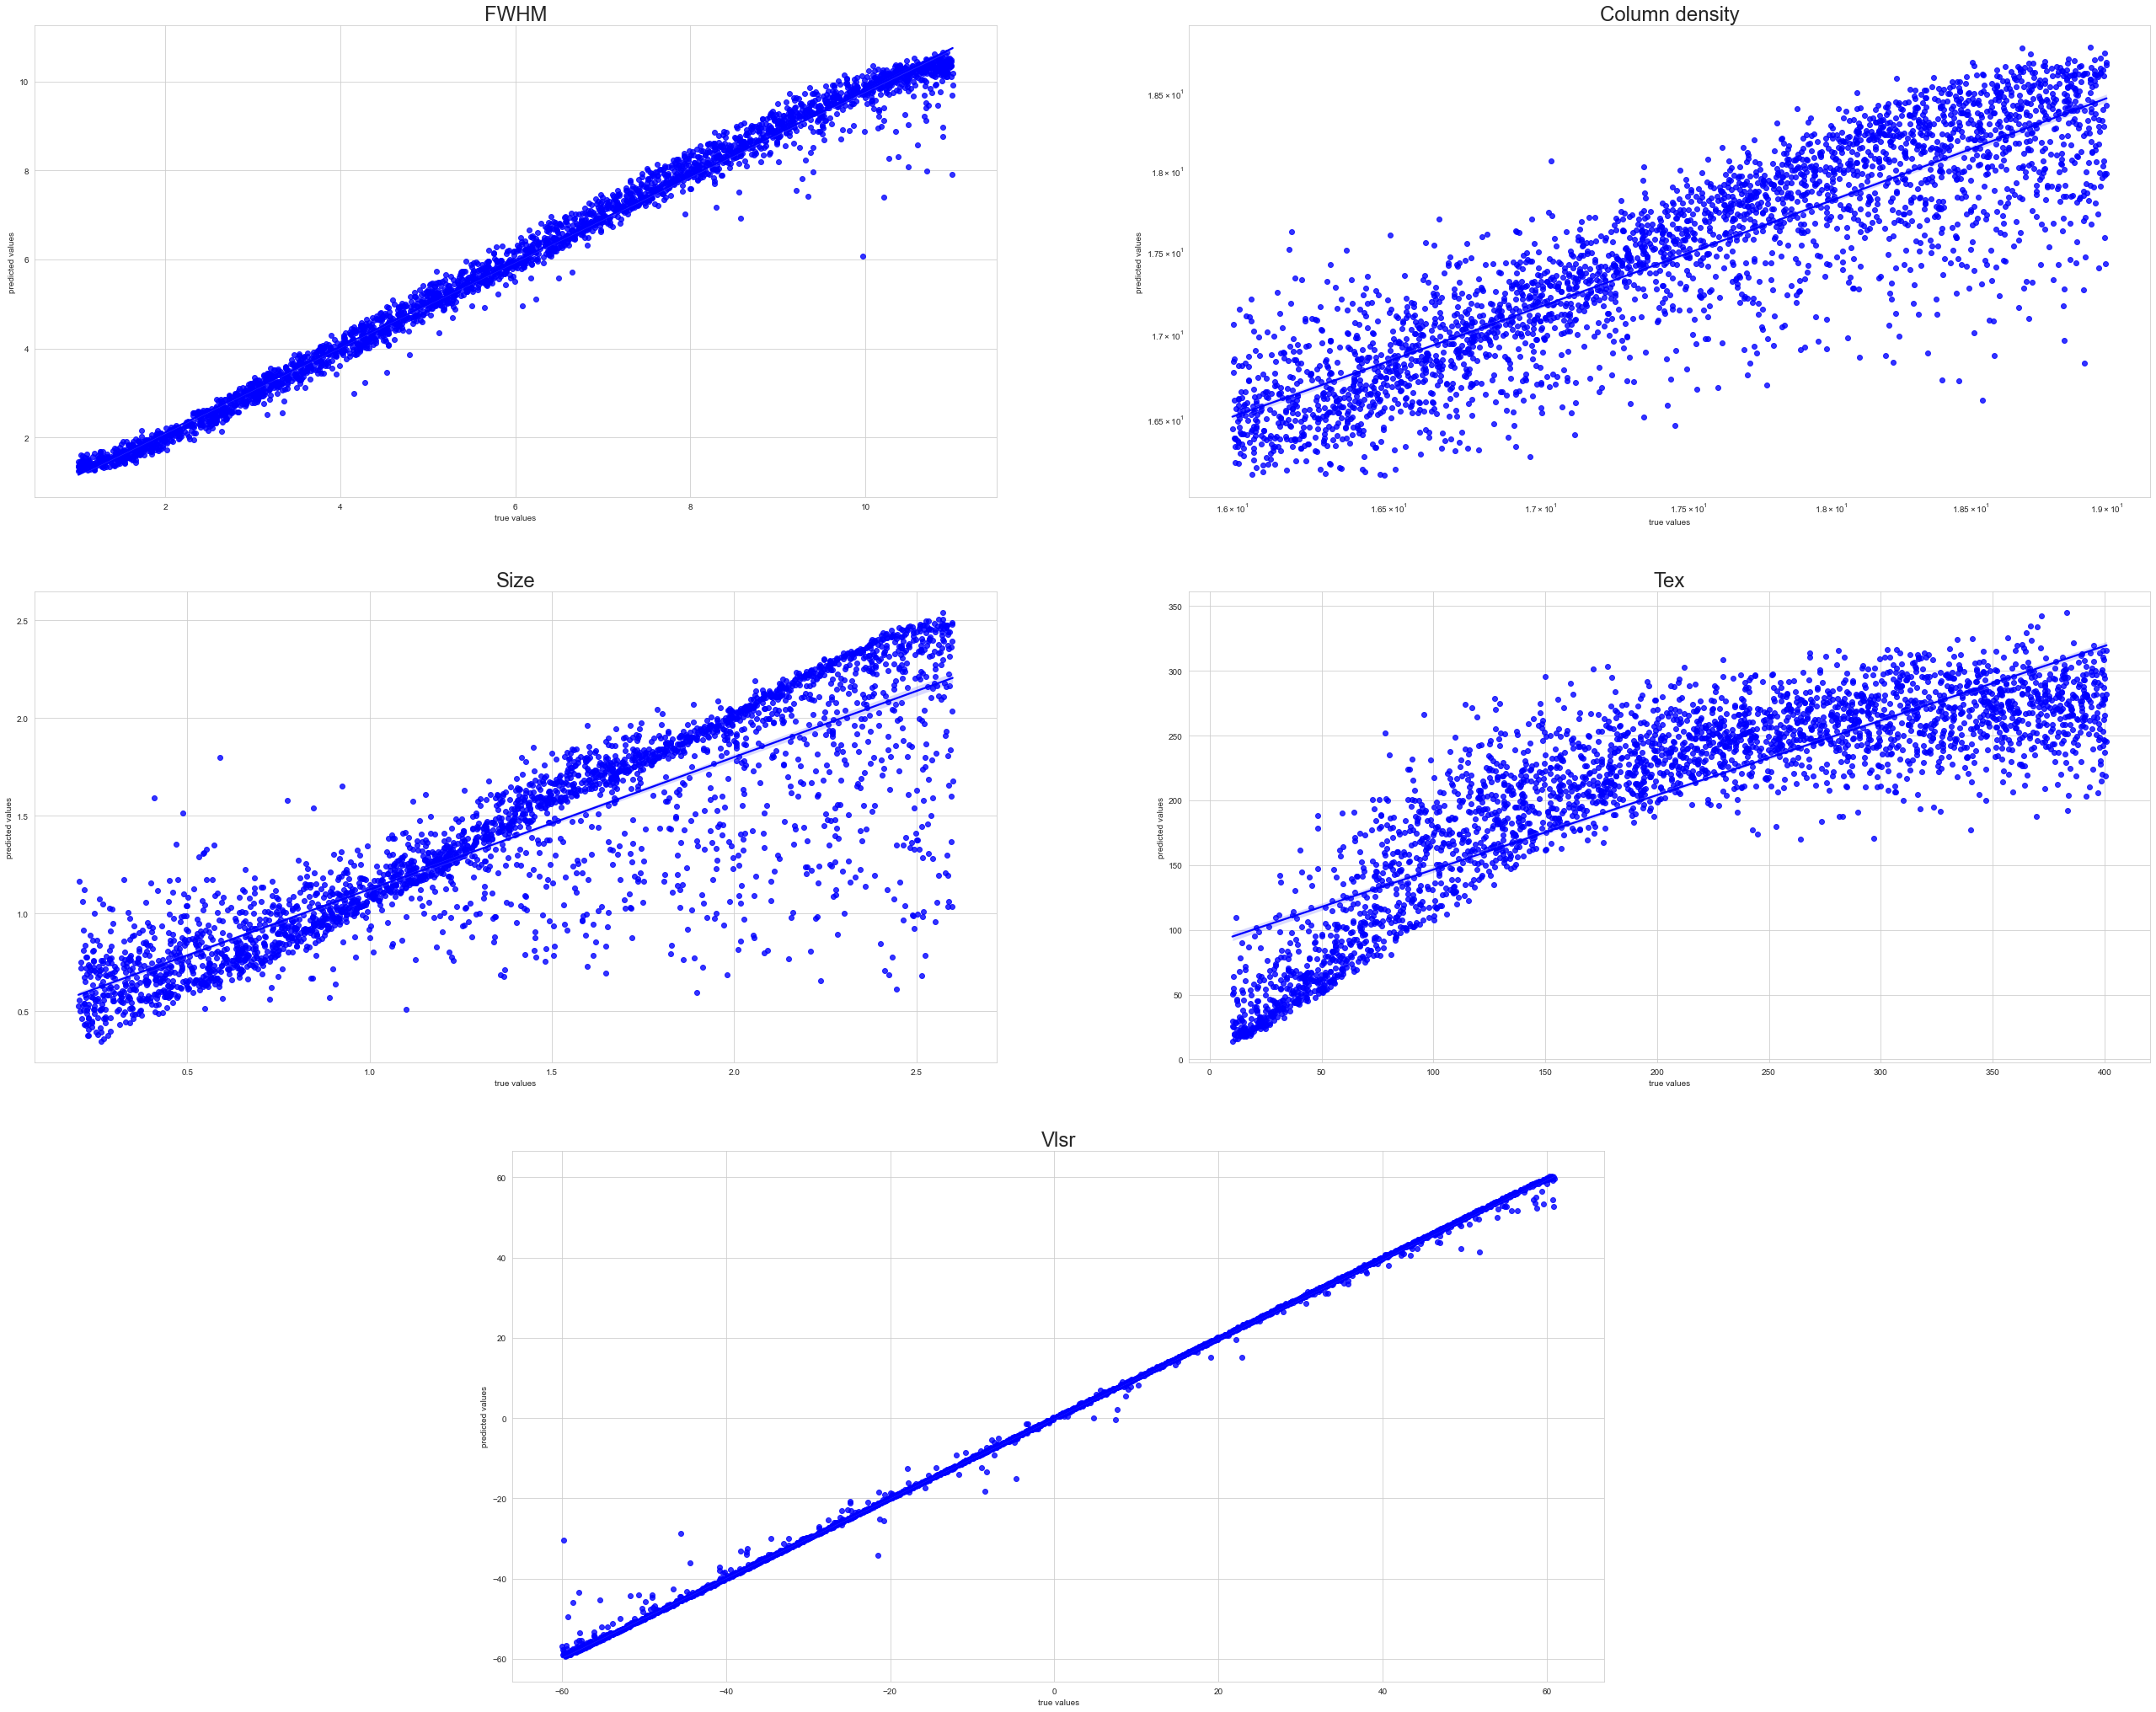

In [50]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig(GENERATED_FILES_OUTPUT + "pred_true_10K_RF.pdf", dpi=15000)
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [51]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf['ntot'] = np.array(10**pred_param_rf['ntot'])
pred_param_rf.head()

fwhm          ntot      size         tex       vlsr
0  4.489740  1.632891e+18  1.200897  243.386491 -17.831494
1  1.524747  1.454780e+17  1.890326  118.199462  13.287437
2  2.523516  6.341560e+16  0.462849   87.034018   1.584097
3  2.106135  9.632910e+16  0.688151  229.566506  28.010700
4  3.664536  1.520483e+18  1.776172  241.248424  34.715283

### Residuals 3D plot -  Random Forest Regressor

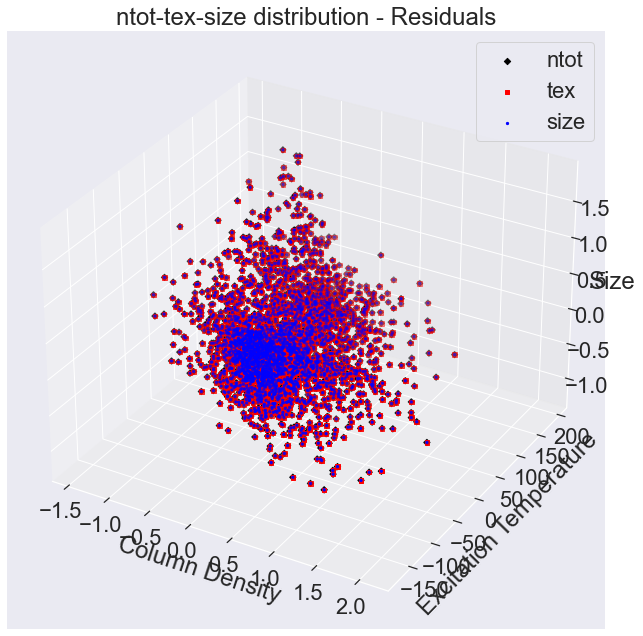

In [52]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

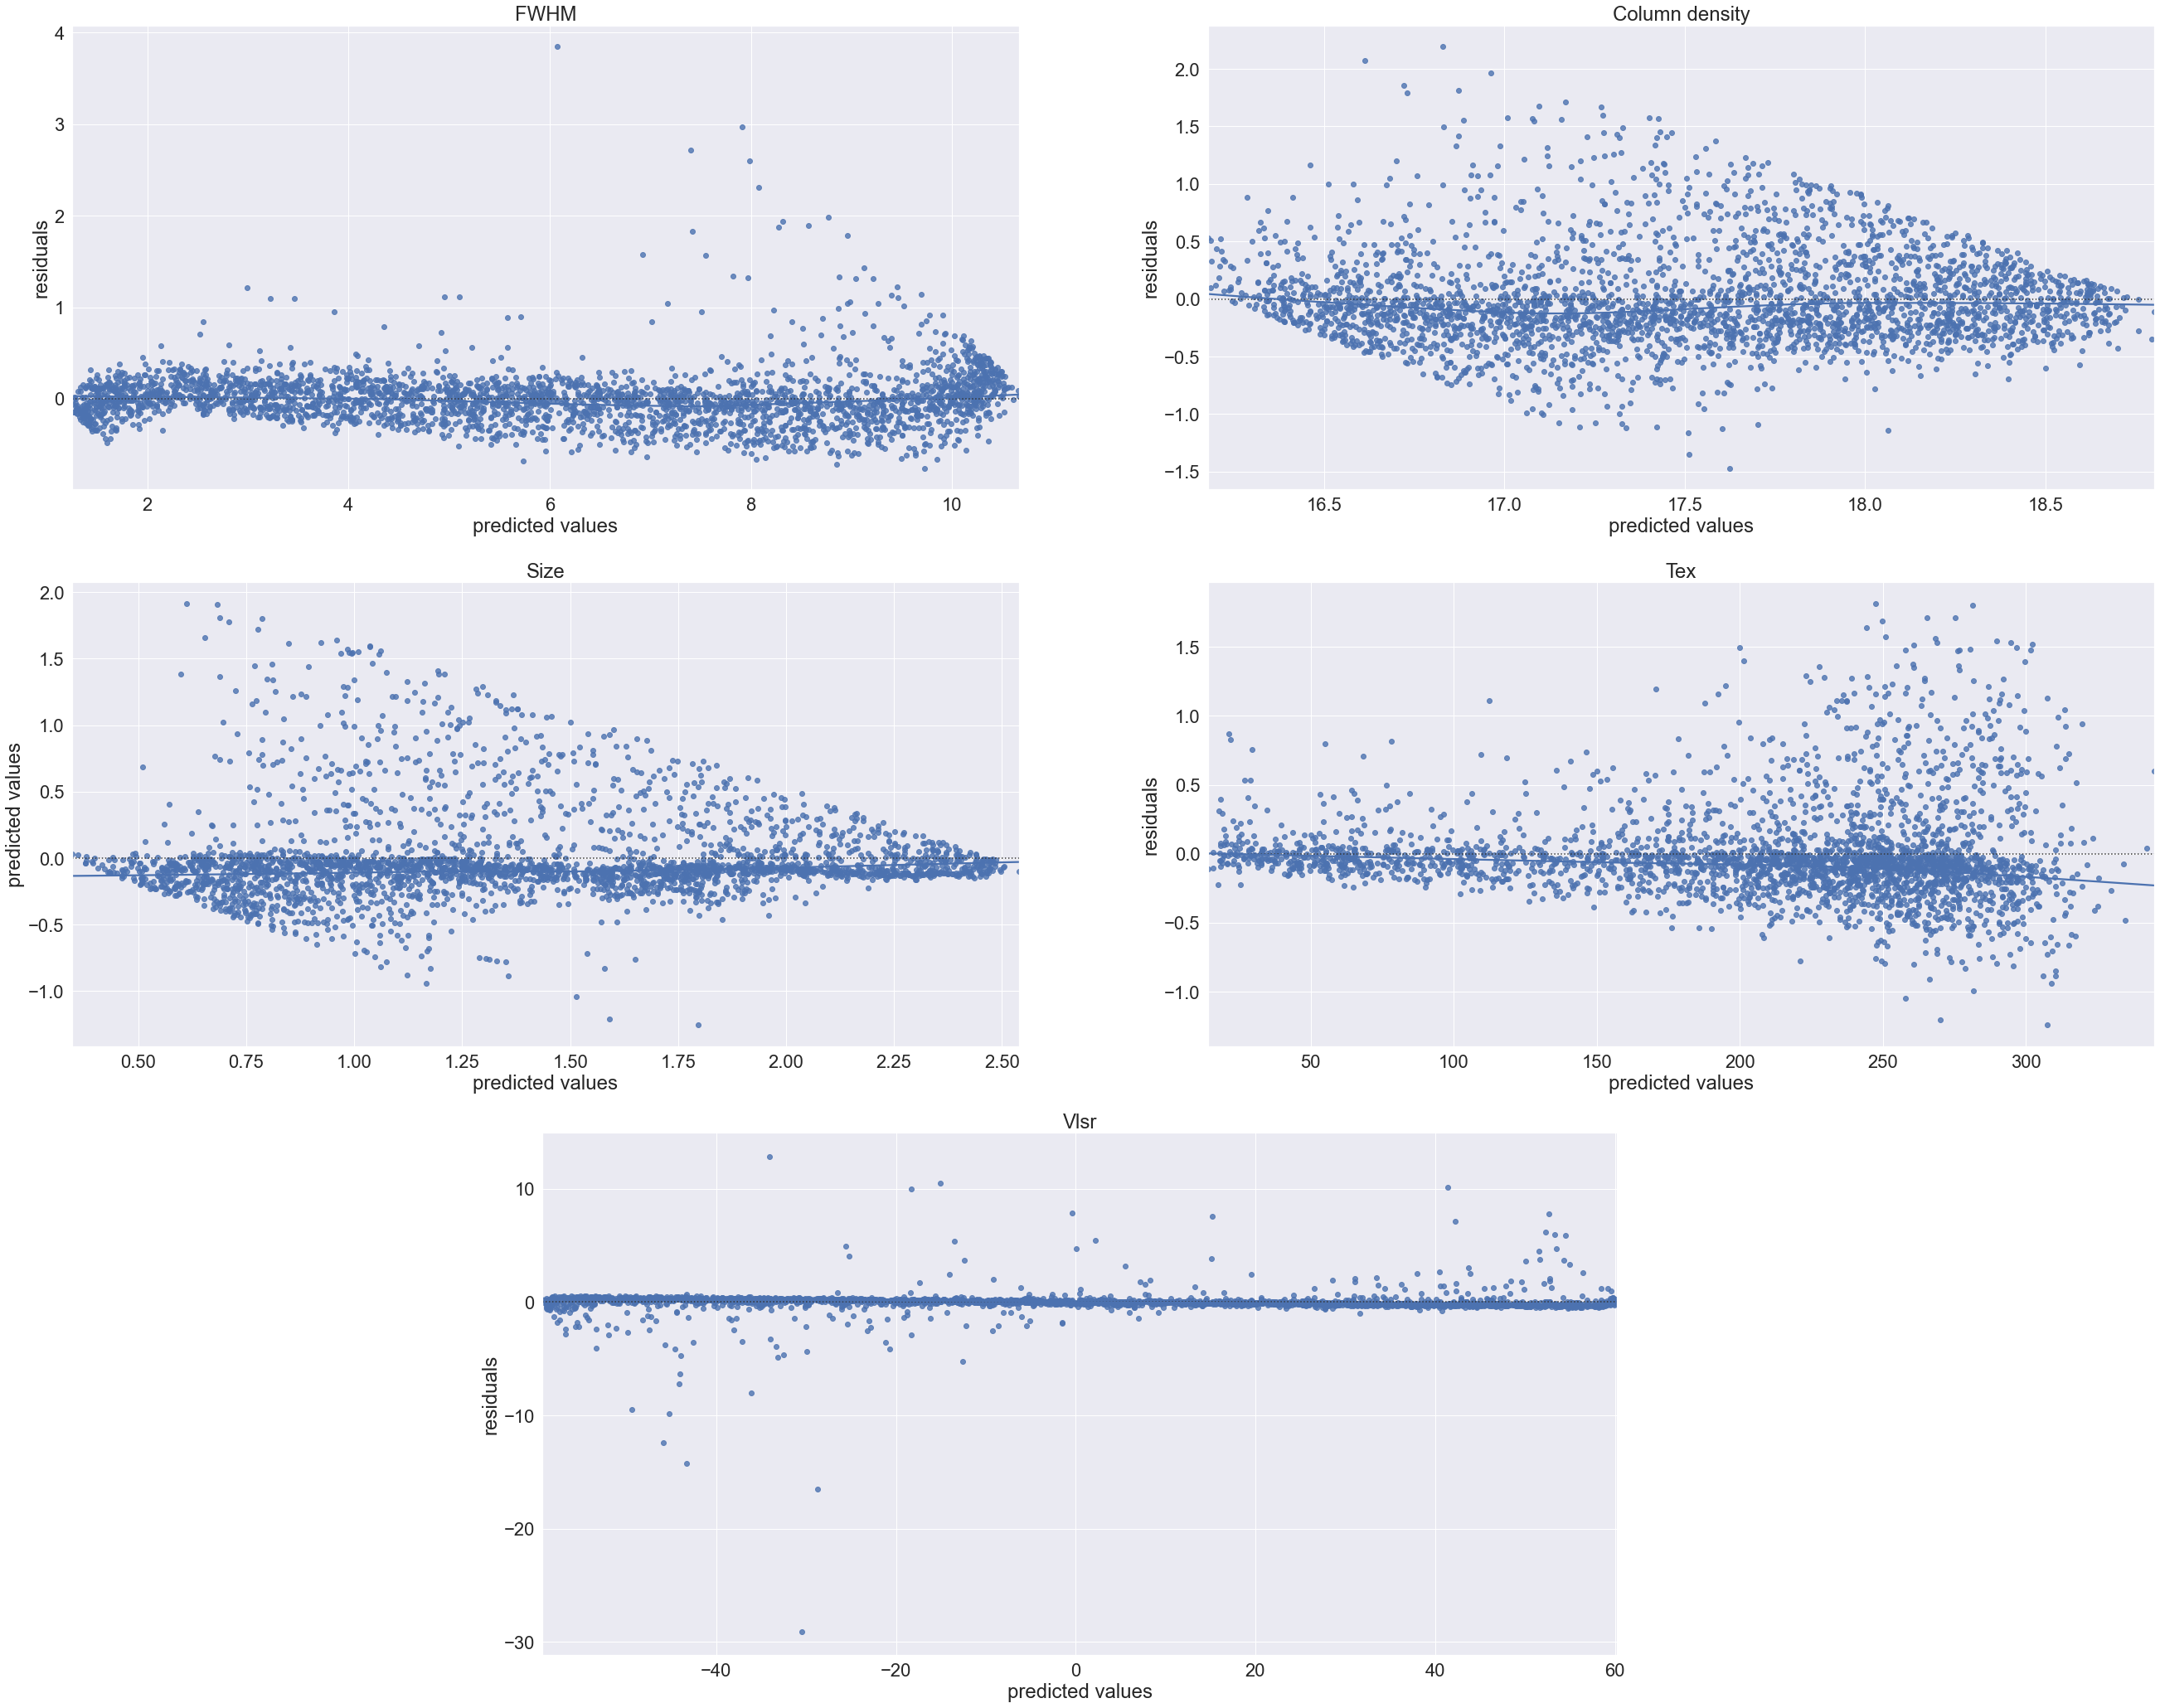

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig(GENERATED_FILES_OUTPUT + "residuals_RF_10K.pdf", dpi=15000)
plt.show()

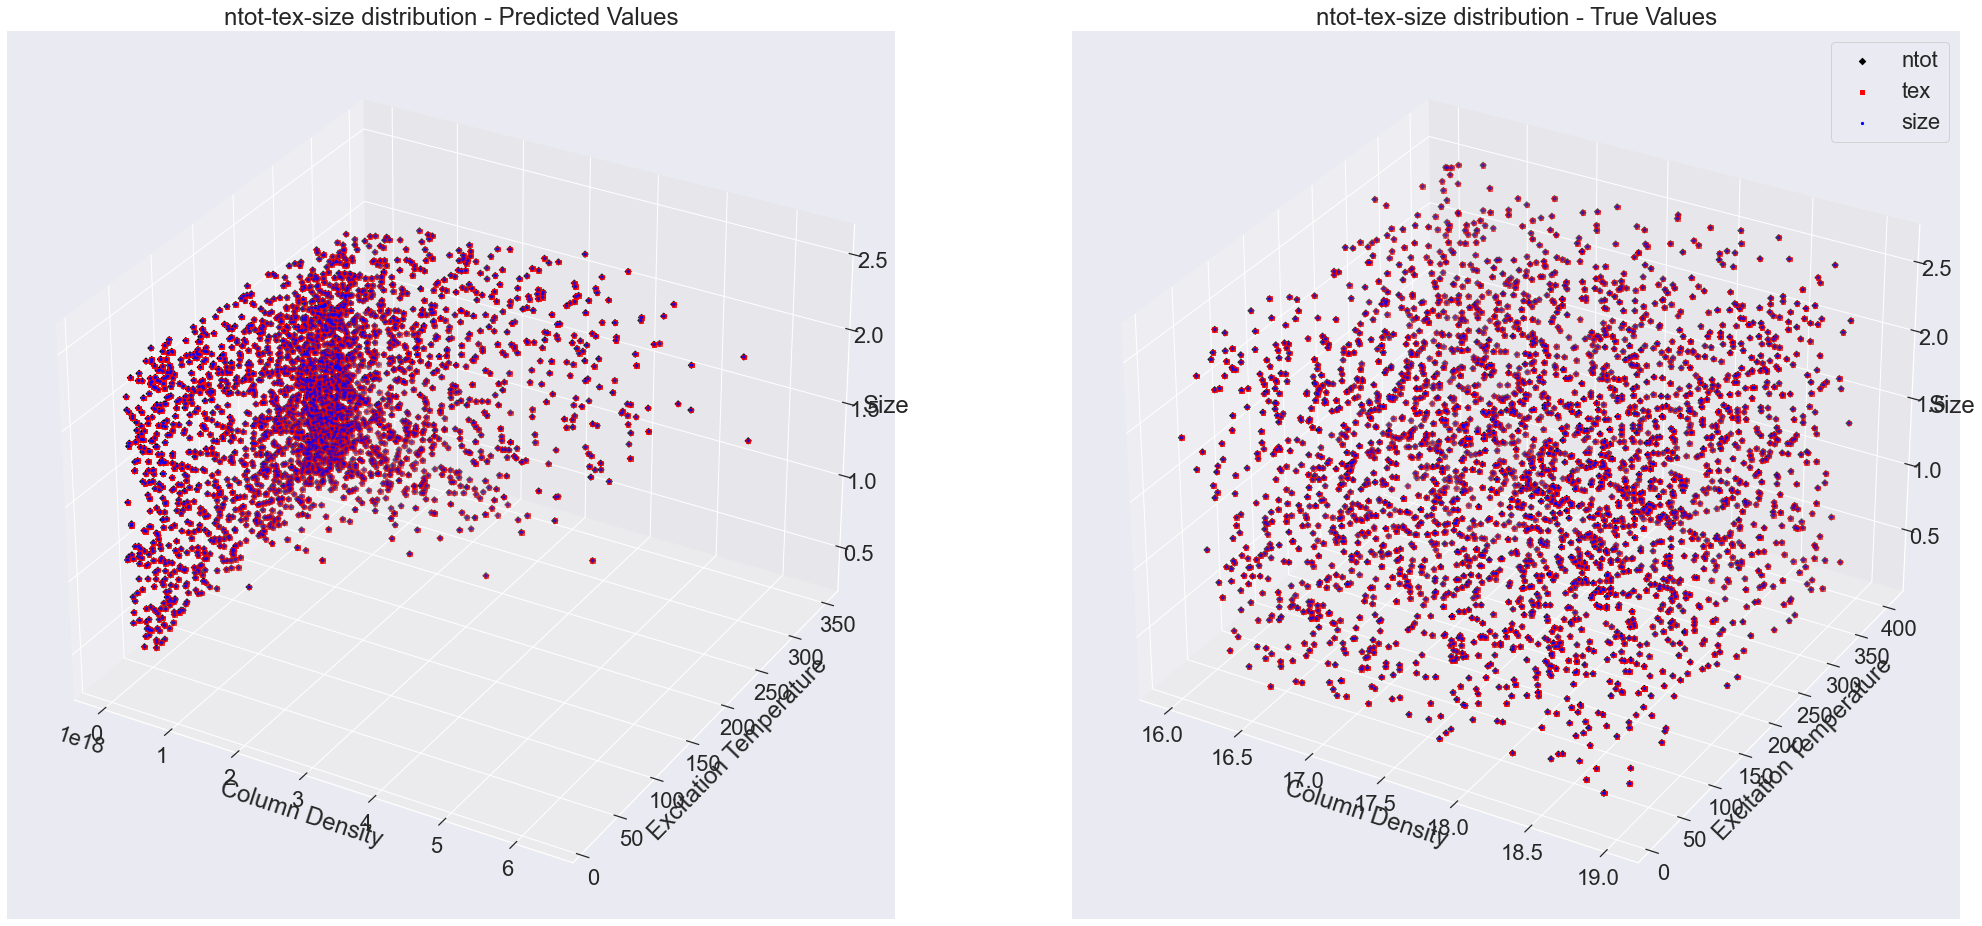

In [54]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig(GENERATED_FILES_OUTPUT + "scatter3D_pred_true_10K_RF.pdf", dpi=15000)
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [55]:
# multirf_model = MultiOutputRegressor(
#     RandomForestRegressor(
#         n_estimators=100,
#         max_depth=10,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         min_weight_fraction_leaf=0.0,
#         criterion="squared_error",
#         bootstrap=True,
#         n_jobs=-1,
#         max_samples=None,
# ))

# multrf_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__min_samples_split=np.arange(2, 10, 2),
#     estimator__min_samples_leaf=np.arange(1, 5, 1),
#     # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
#     # estimator__criterion=["squared_error", "absolute_error"],
#     estimator__max_features=["auto", "sqrt", "log2"],
#     # estimator__max_samples=np.arange(0.5, 1, 0.1),
#     estimator__bootstrap=["True", "False"]
#     )

In [56]:
# random_search = RandomizedSearchCV(
#     estimator=multirf_model,
#     param_distributions=multrf_hyperparameters,
#     n_iter=100,
#     cv=5,
#     verbose=2,
#     error_score="raise",
#     n_jobs=-1,
#     random_state=42,
#     return_train_score=True
# )

In [57]:
# # best parameters from tuned model
# regr_tuned_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=5
#     )
# )

In [58]:
# hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

In [59]:
# y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [60]:
# # # TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [61]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
# g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
# g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
# g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
# g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

# g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
# g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
# g3.set(title='Size', ylabel="predicted values", xlabel="true values")
# g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

# plt.savefig("data/10K_gen_files/pred_true_10K_tuned_RF.png")
# plt.show()

### Residuals - RF Tuned Model

In [62]:
# residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
# residuals_tuned_rf

In [63]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# # plot the redisual distribution using seaborn
# g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
# g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
# g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
# g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
# g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
# g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
# g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
# g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
# g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
# g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

# plt.savefig("data/10K_gen_files/residuals_tuned_RF_10K.png")
# plt.show()

## 2. XGBoost Regressor

In [64]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)
multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7f91027305e0>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [65]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [66]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 6.78042280171362
mse : 409.4439254189441
rmse : 20.23472078925094
mape : fwhm     2.437135
ntot     1.461559
size    20.740517
tex     24.725574
vlsr     7.378188
dtype: float64
r2 : 0.8892064985400102
msle : 20.23472078925094


### save the predicted parameters to a csv file

In [67]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
param_df_xgb['ntot'] = np.array(10**param_df_xgb['ntot'])
param_df_xgb.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_xgb.csv')

In [68]:
param_df_xgb.head()

fwhm          ntot      size         tex       vlsr
0  4.459157  2.082964e+18  1.108071  231.845749 -18.106062
1  1.480799  1.373989e+17  1.683461   50.906948  12.821140
2  2.478827  6.851910e+16  0.618725  149.364044   3.157321
3  2.304916  5.679033e+16  0.674165  265.923309  28.021088
4  3.613552  1.601753e+18  1.771385  265.041046  34.842407

### Save the model to a file

In [69]:
joblib.dump(multixgb_model, MODELS_OUTPUT + 'xgb_model.pkl')

['data/models/xgb_model.pkl']

### Predicted vs True values - XGB Regressor

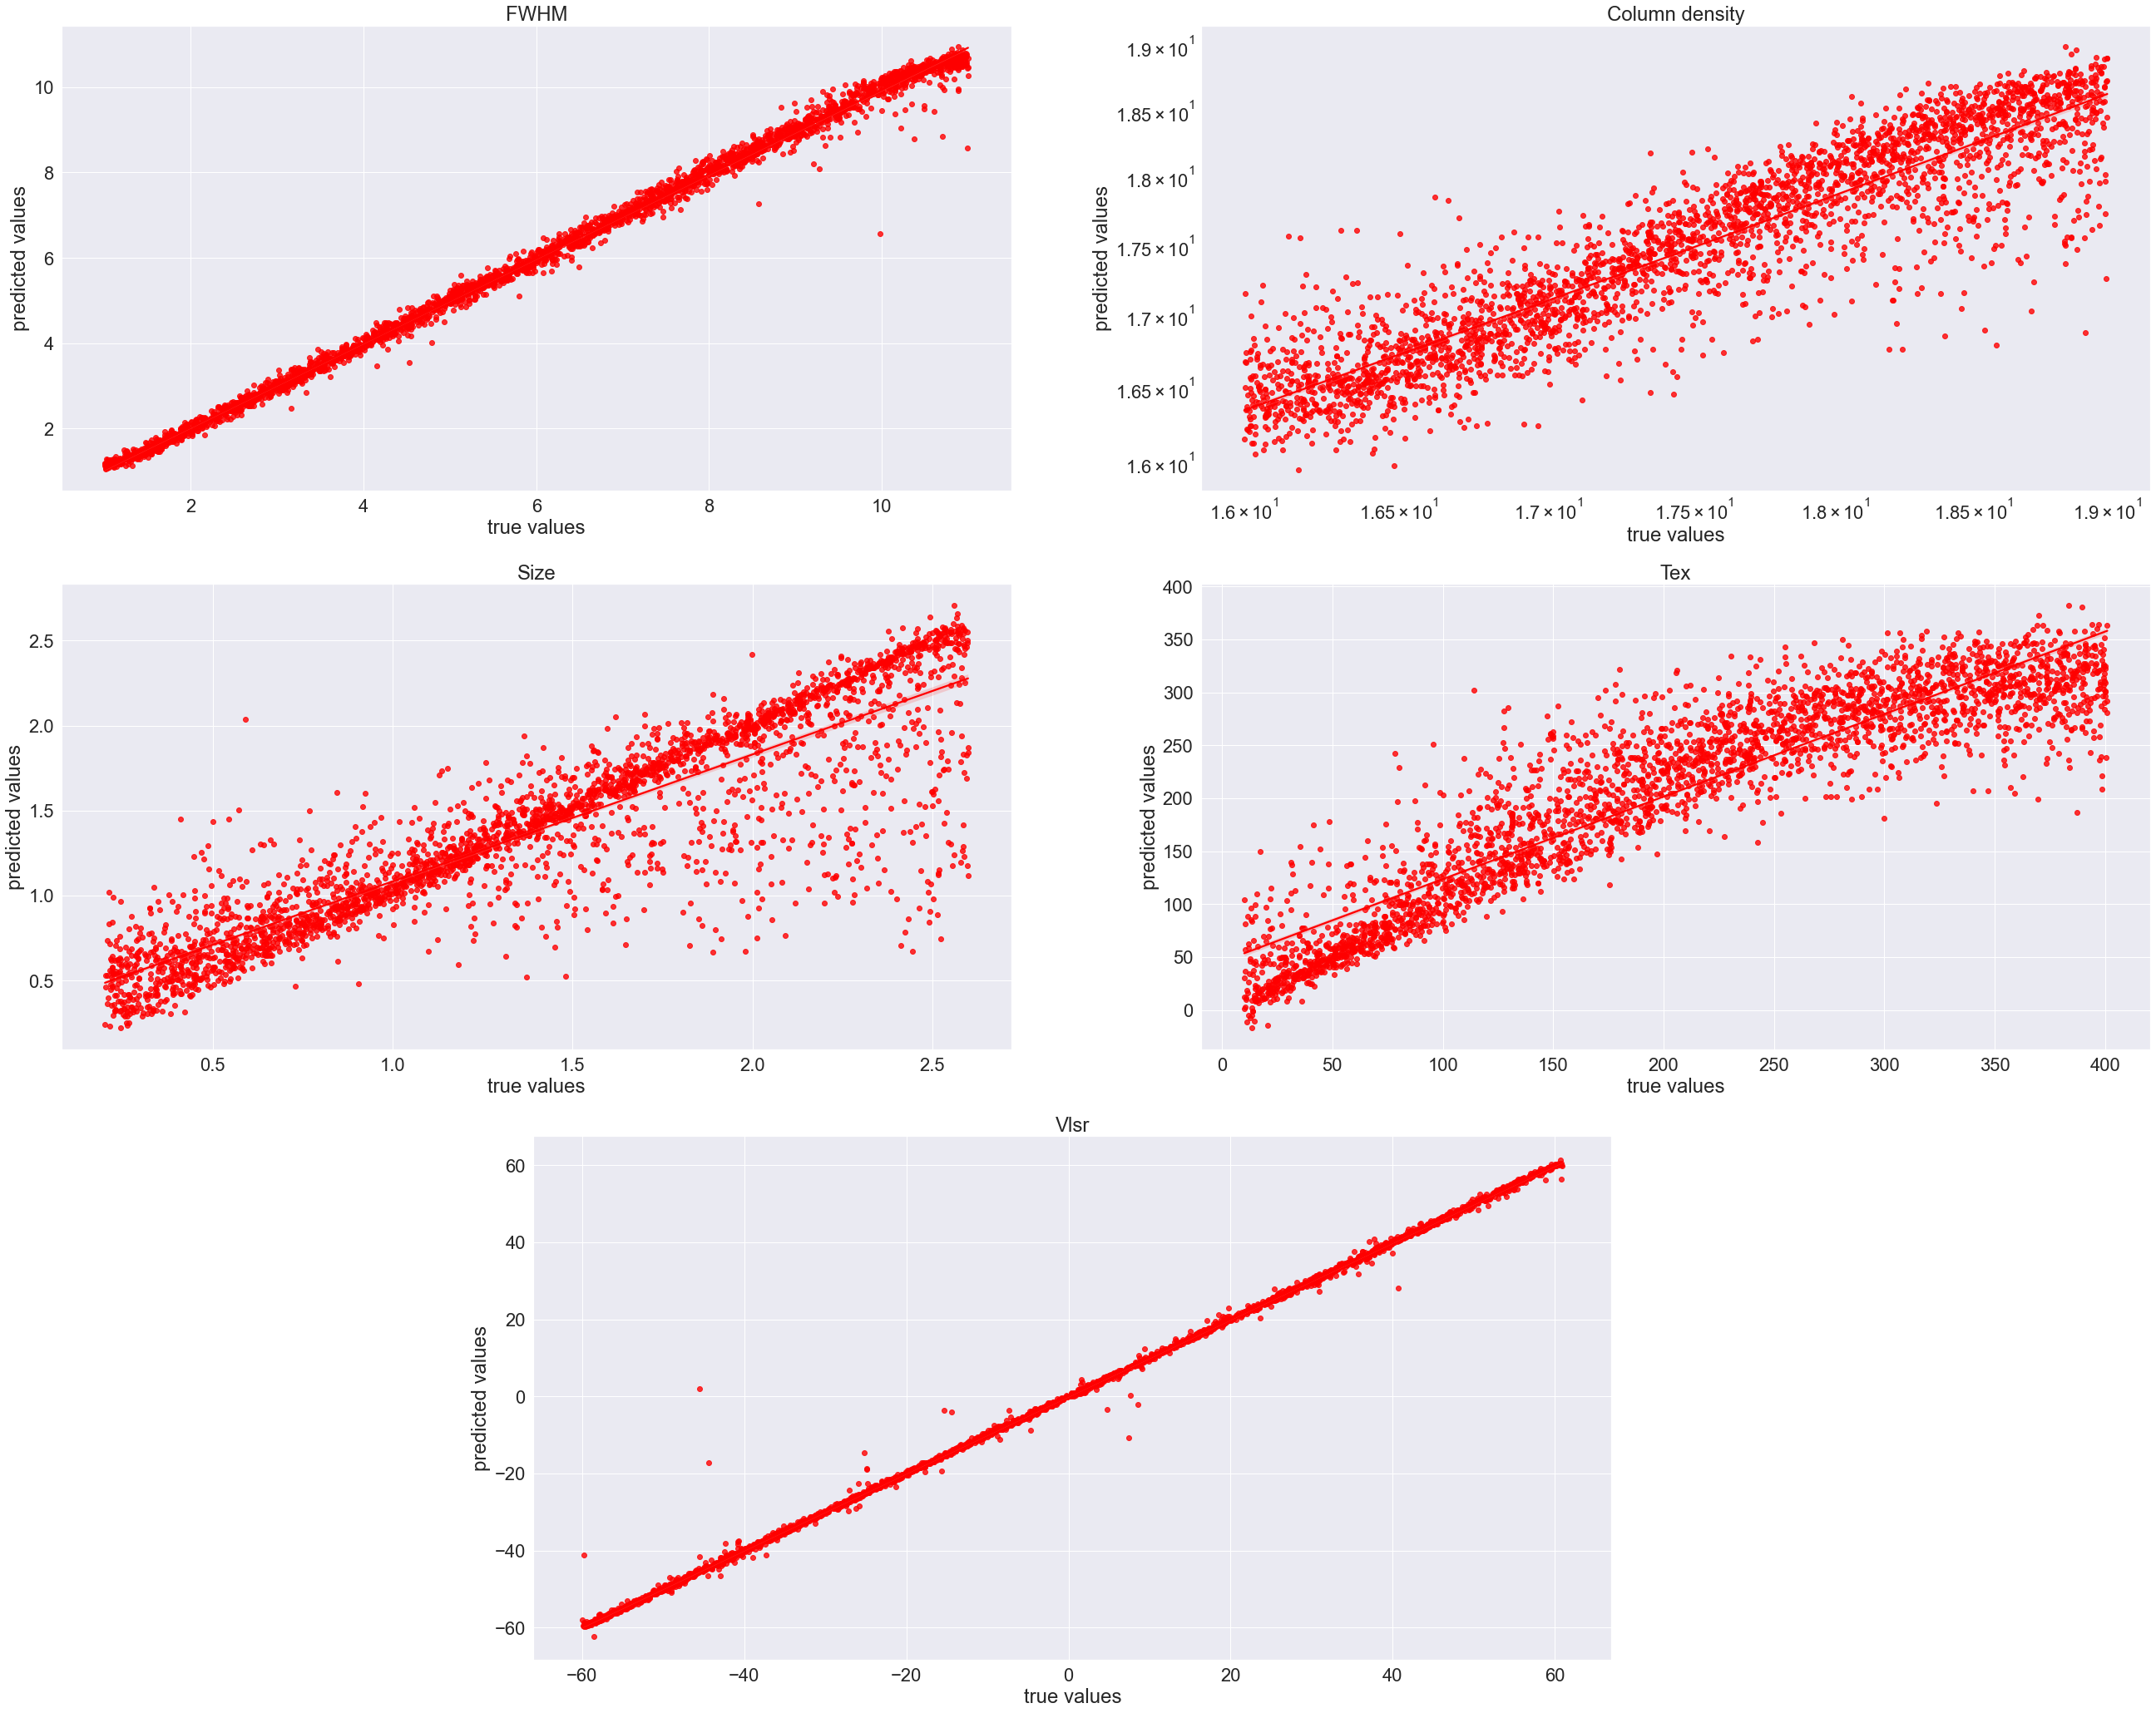

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig(GENERATED_FILES_OUTPUT + "pred_true_10K_XGB.pdf", dpi=15000)
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [71]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb['ntot'] = np.array(10**pred_param_xgb['ntot'])
pred_param_xgb.head()

fwhm          ntot      size         tex       vlsr
0  4.459157  2.082964e+18  1.108071  231.845749 -18.106062
1  1.480799  1.373989e+17  1.683461   50.906948  12.821140
2  2.478827  6.851910e+16  0.618725  149.364044   3.157321
3  2.304916  5.679033e+16  0.674165  265.923309  28.021088
4  3.613552  1.601753e+18  1.771385  265.041046  34.842407

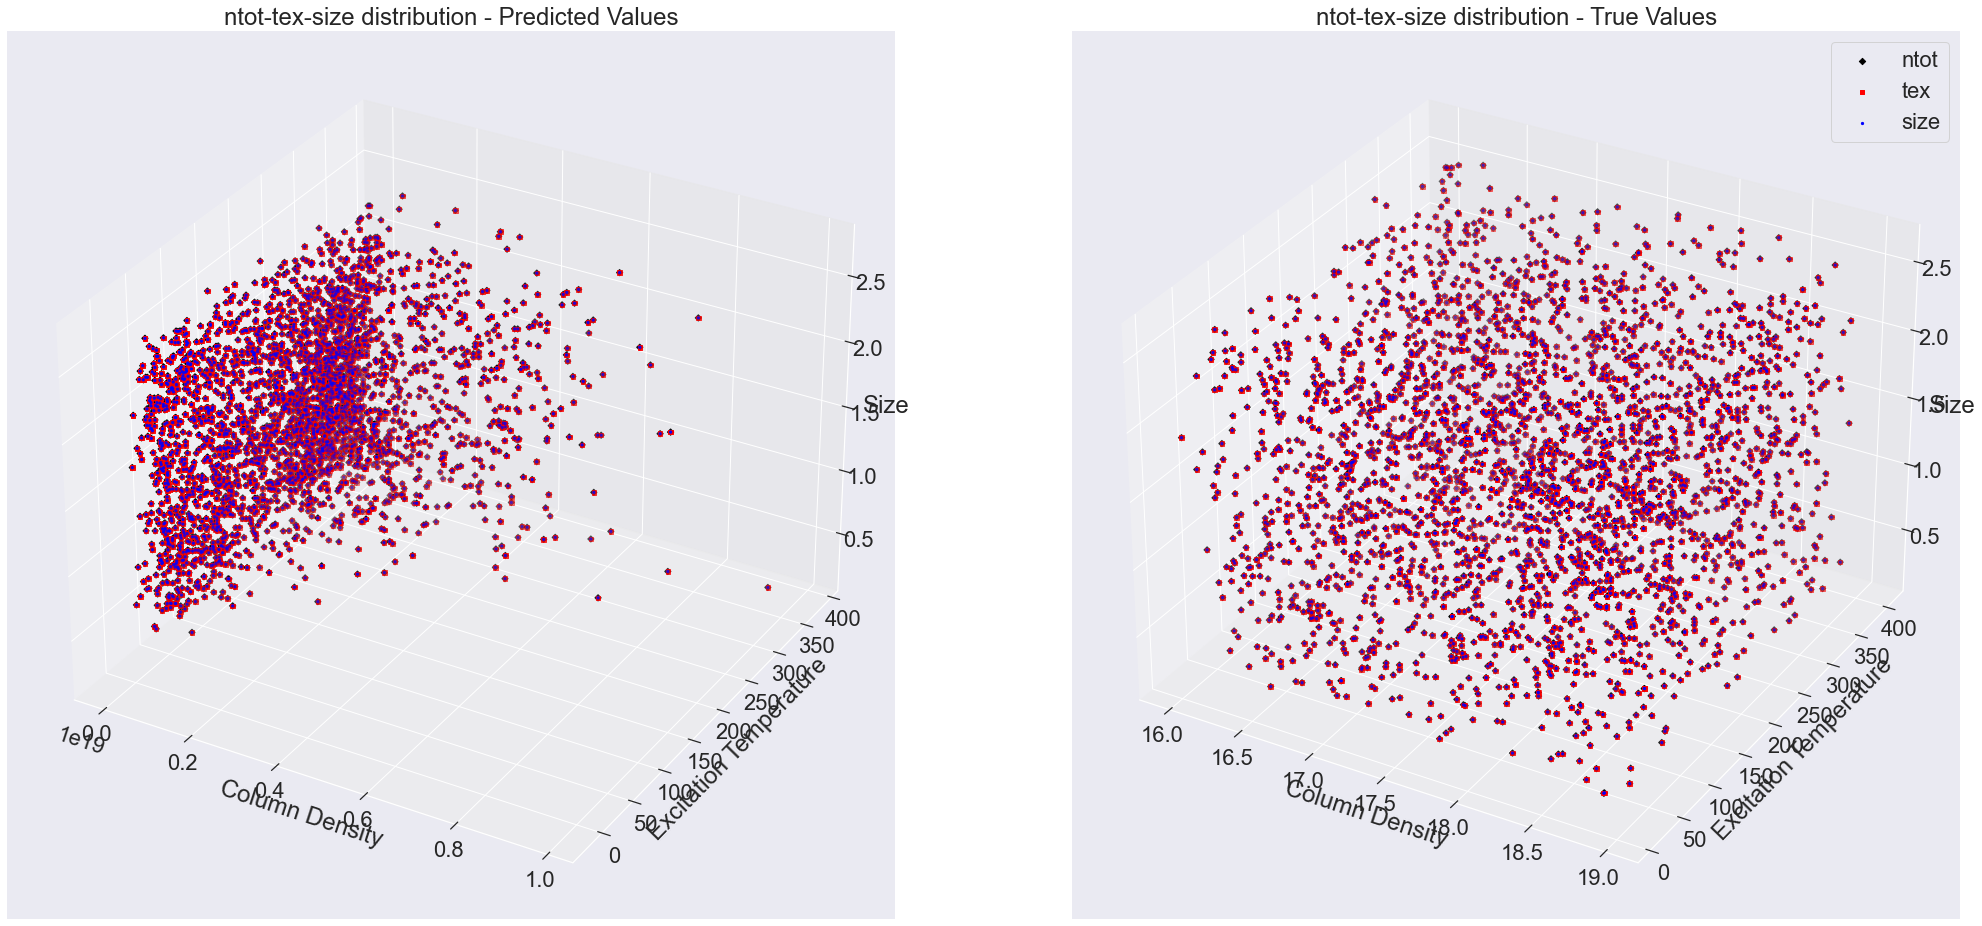

In [72]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig(GENERATED_FILES_OUTPUT + "scatter3D_pred_true_10K_XGB.pdf", dpi=15000)
plt.show()

### Residuals 3D plot - XGB Regressor

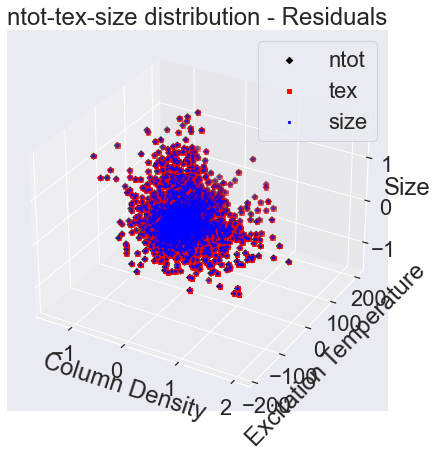

In [73]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

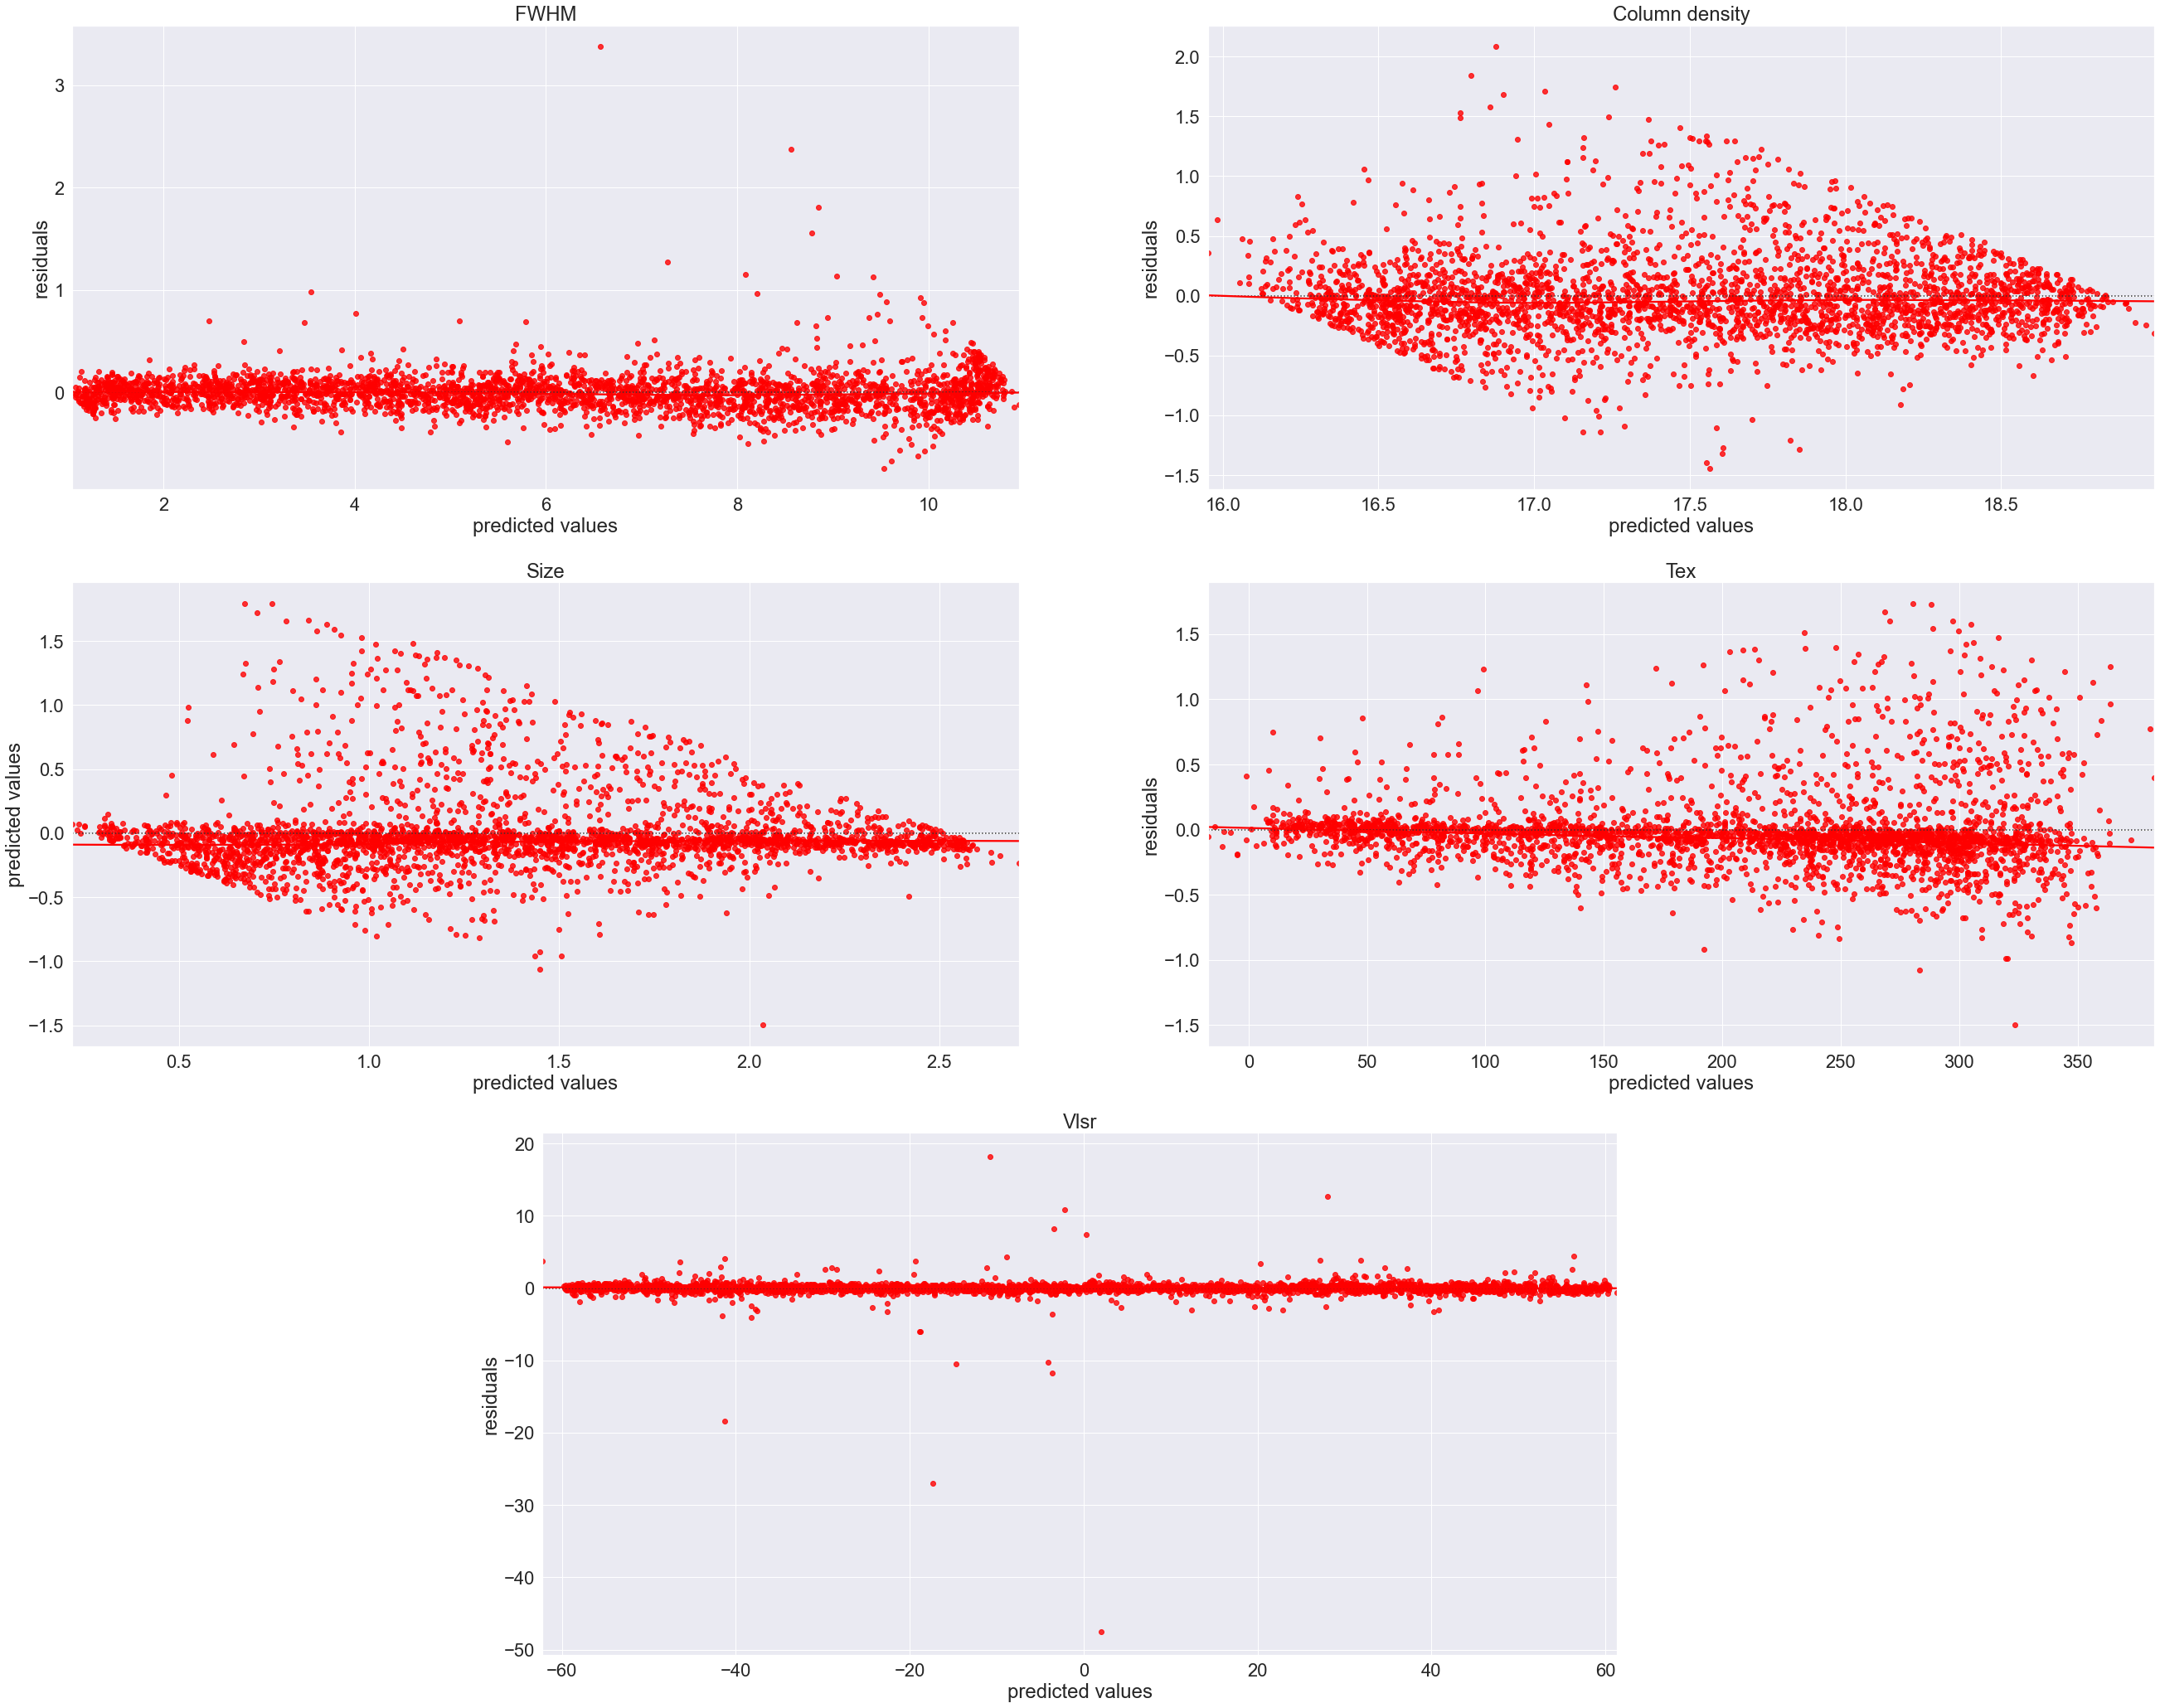

In [74]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig(GENERATED_FILES_OUTPUT + "residuals_XGB_10K.pdf", dpi=15000)
plt.show()

### XGBoost Hyperparameter Tuning

In [75]:
# params = dict(
#     estimator__n_estimators = [100, 200, 500],
#     estimator__learning_rate = [0.01, 0.03, 0.1],
#     estimator__max_depth =  [3, 5, 7, 10],
#     estimator__objective = ['reg:squarederror'],
#     estimator__colsample_bytree = [0.5, 0.7]

# )

# xgb_model = MultiOutputRegressor(
#     xgb.XGBRegressor()
# )

# xgb_gridseach = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=params,
#     cv=5,
#     # scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )


In [76]:
# xgb_gridseach.fit(X_train, y_train)

In [77]:
# xgb_gridseach.best_params_

### Best parameters 

{'estimator__colsample_bytree': 0.5,
 'estimator__learning_rate': 0.03,
 'estimator__max_depth': 10,
 'estimator__n_estimators': 500,
 'estimator__objective': 'reg:squarederror'}

#### Best Fit

In [78]:
#TODO: fill in the best params after tuning
xgb_tuned_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=10,
        colsample_bytree=0.5,
        subsample=0.8,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        objective='reg:squarederror'
    )
)

In [79]:
xgb_tuned_model.fit(X_train, y_train, verbose=True)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.03,
                                            max_delta_step=0, max_depth=10,
                                            min_child_weight=1.0, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
          

In [80]:
y_multixgb_tuned_pred = xgb_tuned_model.predict(X_test)

### metrics

In [81]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_tuned_pred))

mae : 6.431038147030577
mse : 384.6003602516199
rmse : 19.61123046245747
mape : fwhm     1.973352
ntot     1.332374
size    19.145960
tex     22.223900
vlsr     3.806998
dtype: float64
r2 : 0.899465043206132
msle : 19.61123046245747


### save the predicted parameters for the tuned model to a csv file

In [82]:
param_df_xgb_tuned = pd.DataFrame(y_multixgb_tuned_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
param_df_xgb_tuned['ntot'] = np.array(10**param_df_xgb_tuned['ntot'])
param_df_xgb_tuned.to_csv(GENERATED_FILES_OUTPUT + 'predicted_parameters_xgb_tuned.csv')

In [83]:
param_df_xgb_tuned.head()

fwhm          ntot      size         tex       vlsr
6252  4.378325  2.001191e+18  1.118687  247.855331 -17.906527
4684  1.408528  1.438808e+17  1.744987   79.760887  13.262873
1731  2.625195  7.494596e+16  0.460114  123.869156   1.805316
4742  2.298543  5.393571e+16  0.781905  267.300171  28.155193
4521  3.601354  1.671493e+18  1.781608  240.126099  34.492451

#### save the model 

In [84]:
# save the model using joblib
joblib.dump(xgb_tuned_model, MODELS_OUTPUT + 'xgb_tuned_model.pkl')

['data/models/xgb_tuned_model.pkl']

### plot the tuned model tree

In [85]:
# plot_tree(xgb_tuned_model, num_trees=0)
# plt.show()

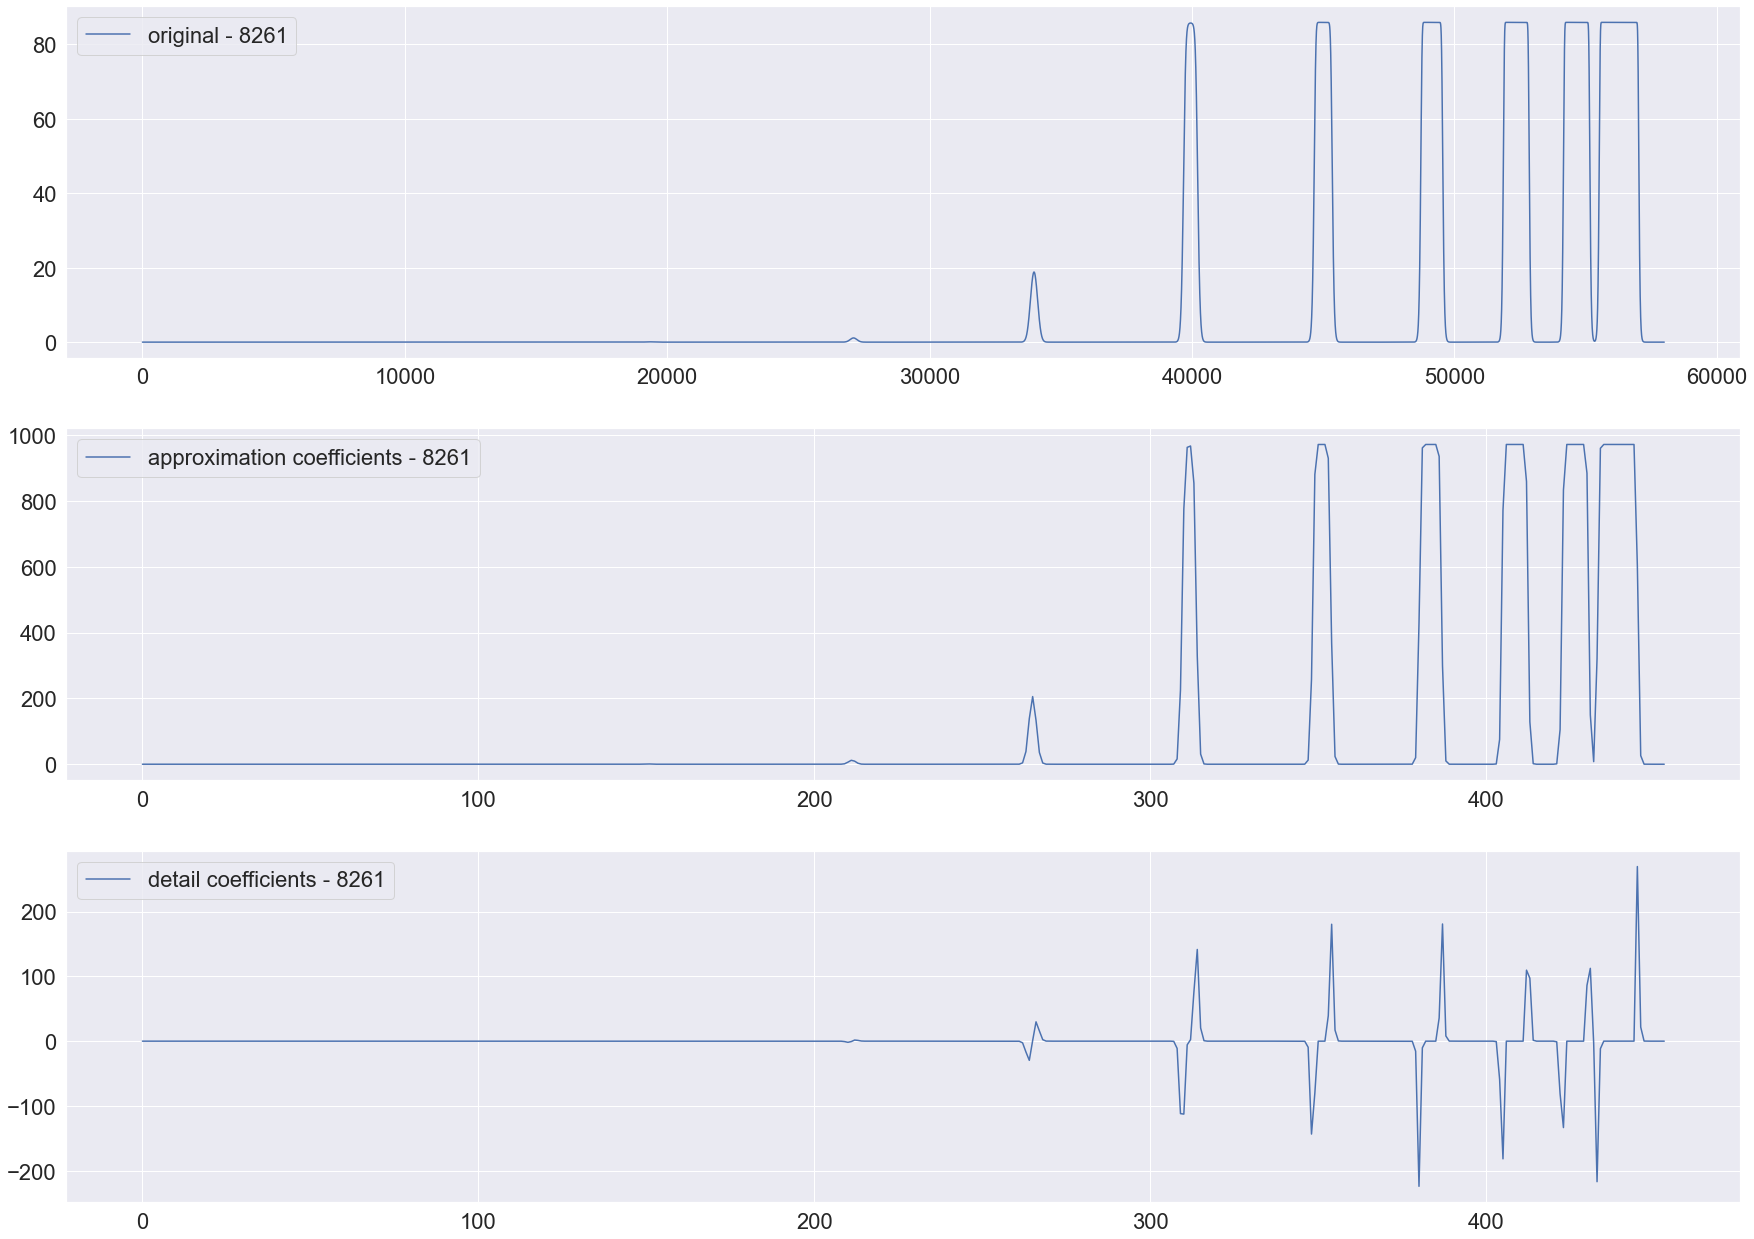

In [86]:
plt.figure(figsize=(30,22))
plt.subplot(3,1,1)
plt.plot(signal[932], label='original - 8261')
plt.legend()
plt.subplot(3,1,2)
plt.plot(approx_coeffs[932], label='approximation coefficients - 8261')
plt.legend()
plt.subplot(3,1,3)
plt.plot(detail_coeffs[932], label='detail coefficients - 8261')
plt.legend()

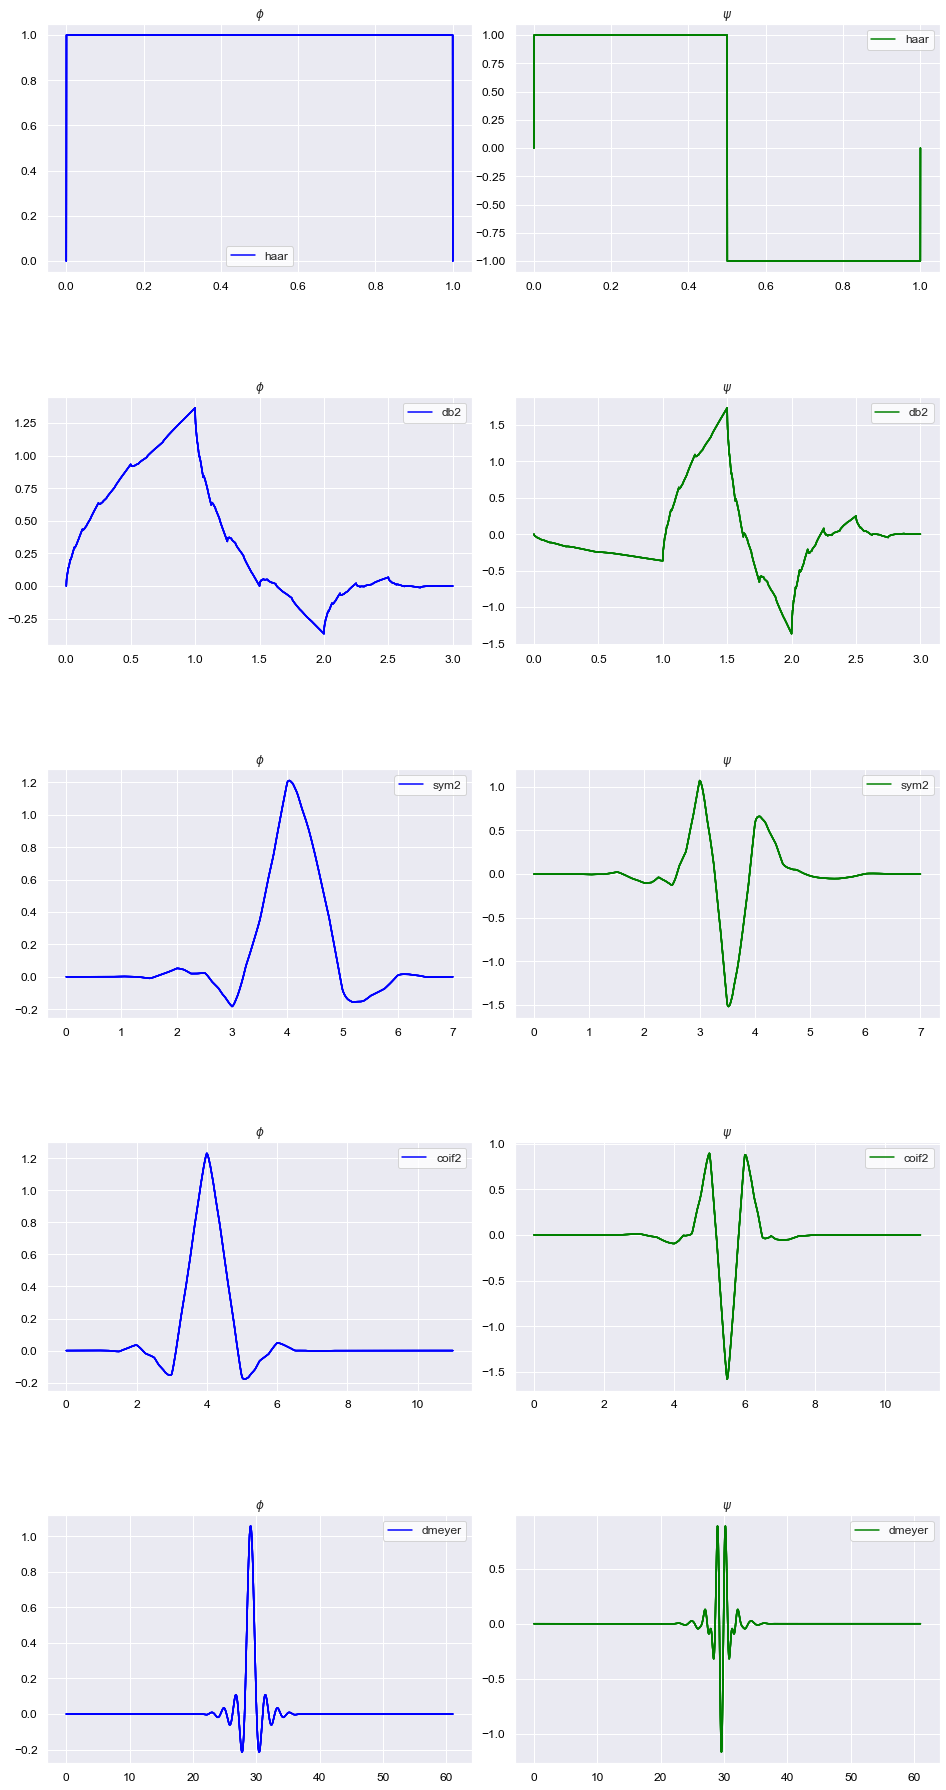

In [87]:
# Daubechies "least asymmetric" wavelets with 12 vanishing points
haar = pywt.Wavelet('haar')
db2 = pywt.Wavelet("db2")
sym2 = pywt.Wavelet("sym4")
coif2 = pywt.Wavelet("coif2")
# bior2 = pywt.Wavelet("bior2.2")
# rbio2 = pywt.Wavelet("rbio2.2")
dmeyer = pywt.Wavelet("dmey")


phi_h, psi_h, x_h = haar.wavefun(level=12)
phi_db2, psi_db2, x_db2 = db2.wavefun(12)
phi_s2, psi_s2, x_s2 = sym2.wavefun(12)
phi_c2, psi_c2, x_c2 = coif2.wavefun(12)
# phi_b, psi_b, x_b = bior2.wavefun(12)
# phi_r2, psi_r2, x_r2 = rbio2.wavefun(12)
phi_d, psi_d, x_d = dmeyer.wavefun(5)



fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,32), gridspec_kw={'hspace': 0.5, 'wspace': 0.1})

sns.set_style('whitegrid', {'axes.grid' : False})
# plt.suptitle("Main Title", size=16)


# loop over the rows and columns of the figure
for i in range(5):
    axes[0, 0].plot(x_h, phi_h, 'blue', label='haar')
    axes[0, 0].legend(['haar'], fontsize=12)
    axes[0, 1].plot(x_h, psi_h, 'green', label='haar')
    axes[0, 1].legend(['haar'], fontsize=12)

    axes[1, 0].plot(x_db2, phi_db2, 'blue', label='db2')
    axes[1, 0].legend(['db2'], fontsize=12)
    axes[1, 1].plot(x_db2, psi_db2, 'green', label='db2')
    axes[1, 1].legend(['db2'], fontsize=12)    

    axes[2, 0].plot(x_s2, phi_s2, 'blue', label='sym2')
    axes[2, 0].legend(['sym2'], fontsize=12)
    axes[2, 1].plot(x_s2, psi_s2, 'green', label='sym2')
    axes[2, 1].legend(['sym2'], fontsize=12)

    axes[3, 0].plot(x_c2, phi_c2, 'blue', label='coif2')
    axes[3, 0].legend(['coif2'], fontsize=12)
    axes[3, 1].plot(x_c2, psi_c2, 'green', label='coif2')
    axes[3, 1].legend(['coif2'], fontsize=12)

    axes[4, 0].plot(x_d, phi_d, 'blue', label='dmeyer')
    axes[4, 0].legend(['dmeyer'], fontsize=12)
    axes[4, 1].plot(x_d, psi_d, 'green', label='dmeyer')
    axes[4, 1].legend(['dmeyer'], fontsize=12)

    # set x and y ticks sizes
    axes[i, 0].tick_params(axis='x', labelsize=12, colors='black')
    axes[i, 0].tick_params(axis='y', labelsize=12, colors='black')
    axes[i, 1].tick_params(axis='x', labelsize=12, colors='black')
    axes[i, 1].tick_params(axis='y', labelsize=12, colors='black')

    axes[i, 0].set_title('$\phi$', fontsize=12, fontweight='bold')
    axes[i, 1].set_title('$\psi$', fontsize=12, fontweight='bold')


plt.savefig(GENERATED_FILES_OUTPUT + 'wavelets_types.pdf', dpi=15000)



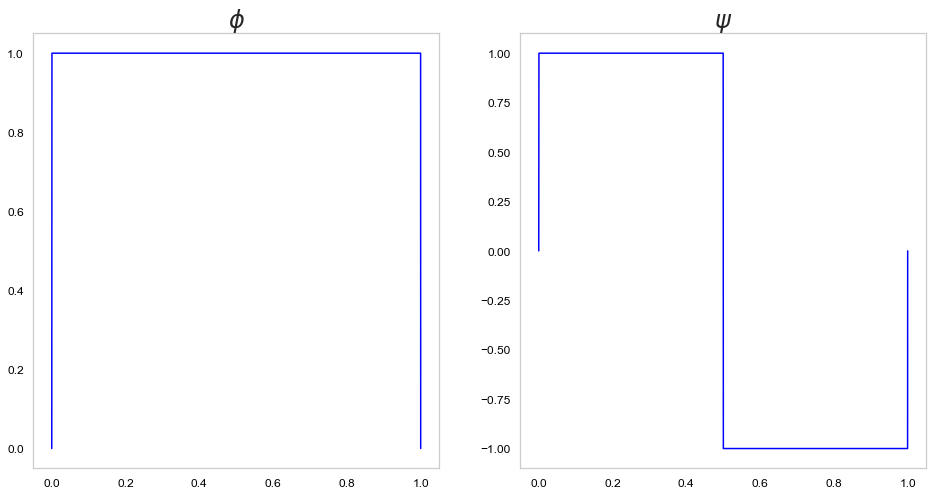

In [88]:
db1 = pywt.Wavelet("db1")
phi_db1, psi_db1, x_db1 = db1.wavefun(12)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title("$\phi$")
plt.plot(x_db1,phi_db1, color='blue')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.title("$\psi$")
plt.plot(x_db1,psi_db1, color='blue')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.savefig(GENERATED_FILES_OUTPUT + 'wavelets_db1.pdf', dpi=15000)



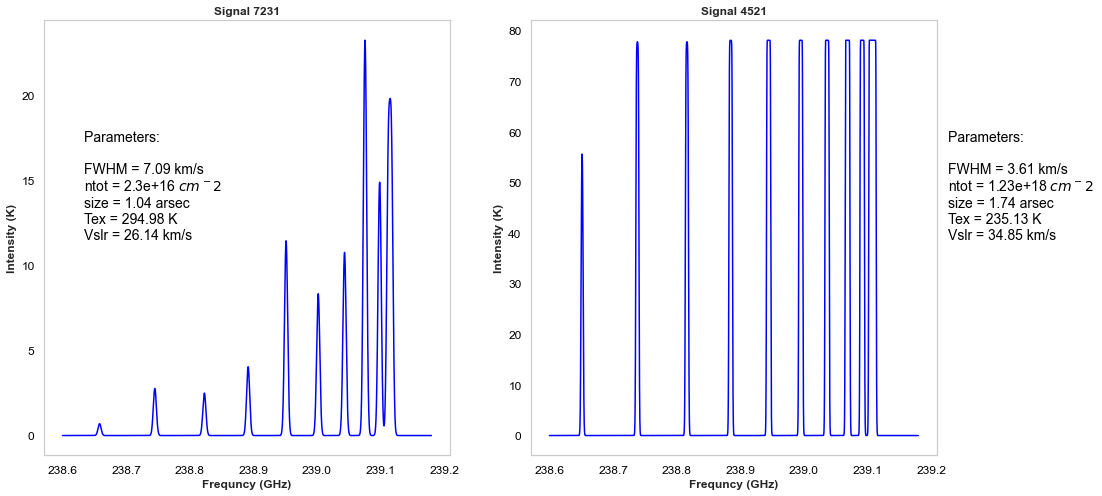

In [89]:
sig7231_params = df_param.iloc[7231, :]
sig4521_params = df_param.iloc[4521, :]


plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(freq_sig[7231],  signal[7231], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.gcf().text(0.16, 0.5, 'Parameters: \n \nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arsec \nTex = {:.2f} K \nVslr = {:.2f} km/s'.format(sig7231_params[0], sig7231_params[1], sig7231_params[2], sig7231_params[3], sig7231_params[4]), fontsize=14, color='black') 
plt.title('Signal 7231', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.plot(freq_sig[4521],  signal[4521], color='blue', label='original - 4521')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.gcf().text(0.91, 0.5, 'Parameters: \n \nFWHM = {:.2f} km/s \nntot = {:.3g} $cm^-2$ \nsize = {:.2f} arsec \nTex = {:.2f} K \nVslr = {:.2f} km/s'.format(sig4521_params[0], sig4521_params[1], sig4521_params[2], sig4521_params[3], sig4521_params[4]), fontsize=14, color='black')
plt.title('Signal 4521', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')

plt.show

plt.savefig(GENERATED_FILES_OUTPUT + 'signal_params.pdf', dpi=15000)


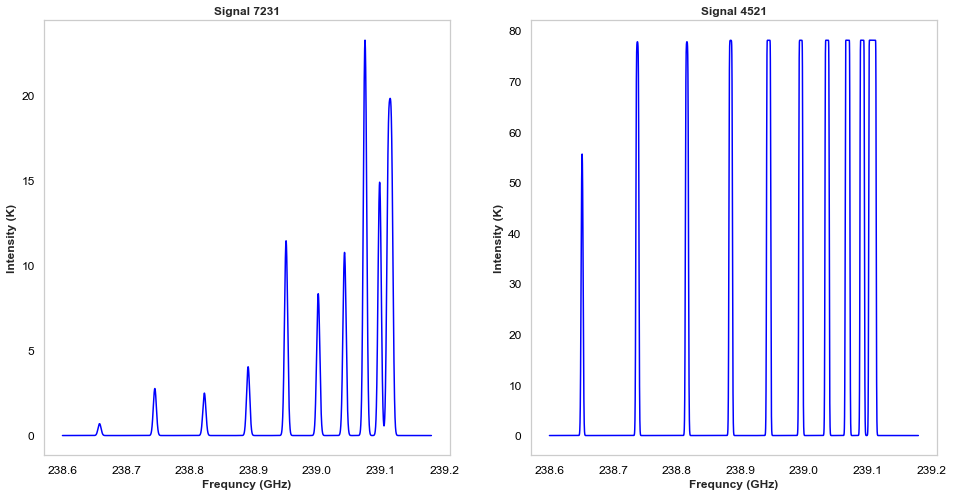

In [90]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(freq_sig[7231],  signal[7231], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.title('Signal 7231', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.subplot(122)
plt.plot(freq_sig[4521],  signal[4521], color='blue', label='original - 7231')
plt.xlabel('Frequncy (GHz)', fontsize=12, fontweight='bold')
plt.ylabel('Intensity (K)', fontsize=12, fontweight='bold')
plt.title('Signal 4521', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', labelsize=12, colors='black')
plt.tick_params(axis='y', labelsize=12, colors='black')
plt.show

plt.savefig(GENERATED_FILES_OUTPUT + 'optically_thick_thin.pdf', dpi=15000)